# Cloud-HPC FMNIST Experiment

In this notebook we construct the necessery code for data analysis, preprocessing, model training and model analysis steps using OSS run in CPouta for orhestration, Allas for storage and Ray in Mahti for compute. You need to have the following:

- MyCSC account
- Project with billing units
- Access to CPouta
- Suitable network rules
- SSH key for CPouta for local and bridge
- Setup Cloud-HPC OSS
- Access to Allas
- Access to Mahti
- SSH setup to Mahti

This notebook uses the following packages:
- pip install jupyterlab
- pip install matplotlib
- pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
- pip install python-decouple
- pip install keystoneauth1 python-keystoneclient python-swiftclient
- pip install kfp~=1.8.14

## Data Analysis

In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as T

image_labels = {
    0: 'Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

regular_transform = T.Compose([
    T.ToTensor()
])

source_train_data = datasets.FashionMNIST(
    root = './data', 
    train = True, 
    download = True, 
    transform = regular_transform
)

source_test_data = datasets.FashionMNIST(
    root = './data', 
    train = False, 
    download = True, 
    transform = regular_transform
)

In [2]:
import matplotlib.pyplot as plt

def first_columnsXrows_images(
    dataset: any,
    labels: any,
    columns: int,
    rows: int
):
    figure = plt.figure(figsize = (10,10))
    for i in range (1, columns * rows + 1):
        image, label = dataset[i]
        figure.add_subplot(
            rows, 
            columns, 
            i
        )
        plt.title(labels[label])
        plt.axis('off')
        plt.imshow(
            image.squeeze(), 
            cmap = 'gray'
        )
    plt.show()

def class_amounts(
    dataset: any,
    labels: any
):
    class_amounts = torch.bincount(dataset.targets)
    print('Class, amount:')
    for i in range(len(labels)):
        print(labels[i], class_amounts[i].item())

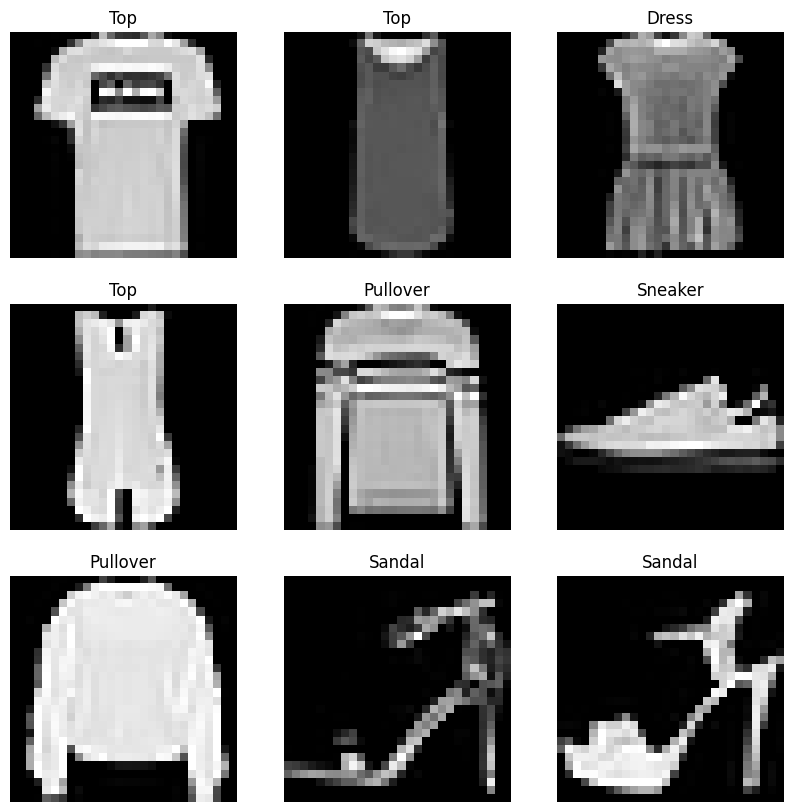

Train set has 60000 instances
Class, amount:
Top 6000
Trouser 6000
Pullover 6000
Dress 6000
Coat 6000
Sandal 6000
Shirt 6000
Sneaker 6000
Bag 6000
Ankle Boot 6000


In [3]:
first_columnsXrows_images(
    dataset = source_train_data,
    labels = image_labels,
    columns = 3,
    rows = 3
)
print('Train set has {} instances'.format(len(source_train_data)))
class_amounts(
    dataset = source_train_data,
    labels = image_labels
)

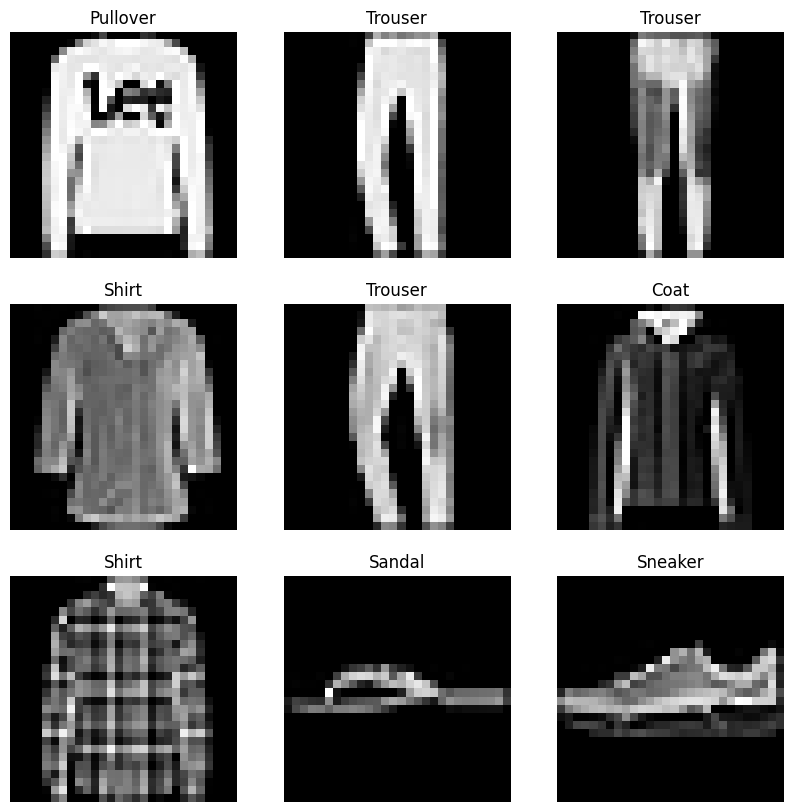

Test set has 10000 instances
Class, amount:
Top 1000
Trouser 1000
Pullover 1000
Dress 1000
Coat 1000
Sandal 1000
Shirt 1000
Sneaker 1000
Bag 1000
Ankle Boot 1000


In [4]:
first_columnsXrows_images(
    dataset = source_test_data,
    labels = image_labels,
    columns = 3,
    rows = 3
)
print('Test set has {} instances'.format(len(source_test_data)))
class_amounts(
    dataset = source_test_data,
    labels = image_labels
)

## Preprocessing and training in Cloud-HPC

## Boilerplate

## Istio

In [4]:
import re
import requests
from urllib.parse import urlsplit

def get_istio_auth_session(url: str, username: str, password: str) -> dict:
    """
    Determine if the specified URL is secured by Dex and try to obtain a session cookie.
    WARNING: only Dex `staticPasswords` and `LDAP` authentication are currently supported
             (we default default to using `staticPasswords` if both are enabled)

    :param url: Kubeflow server URL, including protocol
    :param username: Dex `staticPasswords` or `LDAP` username
    :param password: Dex `staticPasswords` or `LDAP` password
    :return: auth session information
    """
    # define the default return object
    auth_session = {
        "endpoint_url": url,    # KF endpoint URL
        "redirect_url": None,   # KF redirect URL, if applicable
        "dex_login_url": None,  # Dex login URL (for POST of credentials)
        "is_secured": None,     # True if KF endpoint is secured
        "session_cookie": None  # Resulting session cookies in the form "key1=value1; key2=value2"
    }

    # use a persistent session (for cookies)
    with requests.Session() as s:

        ################
        # Determine if Endpoint is Secured
        ################
        resp = s.get(url, allow_redirects=True)
        if resp.status_code != 200:
            raise RuntimeError(
                f"HTTP status code '{resp.status_code}' for GET against: {url}"
            )

        auth_session["redirect_url"] = resp.url

        # if we were NOT redirected, then the endpoint is UNSECURED
        if len(resp.history) == 0:
            auth_session["is_secured"] = False
            return auth_session
        else:
            auth_session["is_secured"] = True

        ################
        # Get Dex Login URL
        ################
        redirect_url_obj = urlsplit(auth_session["redirect_url"])

        # if we are at `/auth?=xxxx` path, we need to select an auth type
        if re.search(r"/auth$", redirect_url_obj.path):

            #######
            # TIP: choose the default auth type by including ONE of the following
            #######

            # OPTION 1: set "staticPasswords" as default auth type
            redirect_url_obj = redirect_url_obj._replace(
                path=re.sub(r"/auth$", "/auth/local", redirect_url_obj.path)
            )
            # OPTION 2: set "ldap" as default auth type
            # redirect_url_obj = redirect_url_obj._replace(
            #     path=re.sub(r"/auth$", "/auth/ldap", redirect_url_obj.path)
            # )

        # if we are at `/auth/xxxx/login` path, then no further action is needed (we can use it for login POST)
        if re.search(r"/auth/.*/login$", redirect_url_obj.path):
            auth_session["dex_login_url"] = redirect_url_obj.geturl()

        # else, we need to be redirected to the actual login page
        else:
            # this GET should redirect us to the `/auth/xxxx/login` path
            resp = s.get(redirect_url_obj.geturl(), allow_redirects=True)
            if resp.status_code != 200:
                raise RuntimeError(
                    f"HTTP status code '{resp.status_code}' for GET against: {redirect_url_obj.geturl()}"
                )

            # set the login url
            auth_session["dex_login_url"] = resp.url

        ################
        # Attempt Dex Login
        ################
        resp = s.post(
            auth_session["dex_login_url"],
            data={"login": username, "password": password},
            allow_redirects=True
        )
        if len(resp.history) == 0:
            raise RuntimeError(
                f"Login credentials were probably invalid - "
                f"No redirect after POST to: {auth_session['dex_login_url']}"
            )

        # store the session cookies in a "key1=value1; key2=value2" string
        auth_session["session_cookie"] = "; ".join([f"{c.name}={c.value}" for c in s.cookies])

    return auth_session

### General Functions

In [5]:
def set_formatted_user(
    user: str   
) -> any:
    return re.sub(r'[^a-z0-9]+', '-', user)

## SWIFT Functions

In [6]:
from decouple import Config,RepositoryEnv
from keystoneauth1 import loading, session
from keystoneauth1.identity import v3
from keystoneclient.v3 import client as keystone_client
import swiftclient as sc
import pickle

In [7]:
def is_swift_client(
    storage_client: any
) -> any:
    return isinstance(storage_client, sc.Connection)

def swift_setup_client(
    pre_auth_url: str,
    pre_auth_token: str,
    user_domain_name: str,
    project_domain_name: str,
    project_name: str,
    auth_version: str
) -> any:
    swift_client = sc.Connection(
        preauthurl = pre_auth_url,
        preauthtoken = pre_auth_token,
        os_options = {
            'user_domain_name': user_domain_name,
            'project_domain_name': project_domain_name,
            'project_name': project_name
        },
        auth_version = auth_version
    )
    return swift_client

def swift_create_bucket(
    swift_client: any,
    bucket_name: str
) -> bool:
    try:
        swift_client.put_container(
            container = bucket_name
        )
        return True
    except Exception as e:
        return False

def swift_check_bucket(
    swift_client: any,
    bucket_name:str
) -> any:
    try:
        bucket_info = swift_client.get_container(
            container = bucket_name
        )
        bucket_metadata = bucket_info[0]
        list_of_objects = bucket_info[1]
        return {'metadata': bucket_metadata, 'objects': list_of_objects}
    except Exception as e:
        return {} 

def swift_delete_bucket(
    swift_client: any,
    bucket_name: str
) -> bool:
    try:
        swift_client.delete_container(
            container = bucket_name
        )
        return True
    except Exception as e:
        return False

def swift_list_buckets(
    swift_client: any
) -> any:
    try:
        account_buckets = swift_client.get_account()[1]
        buckets = {}
        for bucket in account_buckets:
            bucket_name = bucket['name']
            bucket_count = bucket['count']
            bucket_size = bucket['bytes']
            buckets[bucket_name] = {
                'amount': bucket_count,
                'size': bucket_size
            }
        return buckets
    except Exception as e:
        return {}

def swift_create_object(
    swift_client: any,
    bucket_name: str, 
    object_path: str, 
    object_data: any,
    object_metadata: any
) -> bool: 
    try:
        swift_client.put_object(
            container = bucket_name,
            obj = object_path,
            contents = object_data,
            headers = object_metadata
        )
        return True
    except Exception as e:
        return False

def swift_check_object(
    swift_client: any,
    bucket_name: str, 
    object_path: str
) -> any: 
    try:
        object_metadata = swift_client.head_object(
            container = bucket_name,
            obj = object_path
        )       
        return object_metadata
    except Exception as e:
        return {} 

def swift_get_object(
    swift_client:any,
    bucket_name: str,
    object_path: str
) -> any:
    try:
        response = swift_client.get_object(
            container = bucket_name,
            obj = object_path 
        )
        object_info = response[0]
        object_data = response[1]
        return {'data': object_data, 'info': object_info}
    except Exception as e:
        return {}     
   
def swift_remove_object(
    swift_client: any,
    bucket_name: str, 
    object_path: str
) -> bool: 
    try:
        swift_client.delete_object(
            container = bucket_name, 
            obj = object_path
        )
        return True
    except Exception as e:
        return False

def swift_update_object(
    swift_client: any,
    bucket_name: str, 
    object_path: str, 
    object_data: any,
    object_metadata: any
) -> bool:  
    remove = swift_remove_object(
        swift_client = swift_client, 
        bucket_name = bucket_name, 
        object_path = object_path
    )
    if not remove:
        return False
    create = swift_create_object(
        swift_client = swift_client, 
        bucket_name = bucket_name, 
        object_path = object_path, 
        object_data = object_data,
        object_metadata = object_metadata
    )
    return create

def swift_create_or_update_object(
    swift_client: any,
    bucket_name: str, 
    object_path: str, 
    object_data: any,
    object_metadata: any
) -> any:
    bucket_info = swift_check_bucket(
        swift_client = swift_client, 
        bucket_name = bucket_name
    )
    
    if len(bucket_info) == 0:
        creation_status = swift_create_bucket(
            swift_client = swift_client, 
            bucket_name = bucket_name
        )
        if not creation_status:
            return False
    
    object_info = swift_check_object(
        swift_client = swift_client, 
        bucket_name = bucket_name, 
        object_path = object_path
    )
    
    if len(object_info) == 0:
        return swift_create_object(
            swift_client = swift_client, 
            bucket_name = bucket_name, 
            object_path = object_path, 
            object_data = object_data,
            object_metadata = object_metadata
        )
    else:
        return swift_update_object(
            swift_client = swift_client, 
            bucket_name = bucket_name, 
            object_path = object_path, 
            object_data = object_data,
            object_metadata = object_metadata
        )

## Storage Functions

In [8]:
def set_encoded_metadata(
    used_client: str,
    object_metadata: any
) -> any:
    encoded_metadata = {}
    if used_client == 'swift':
        key_initial = 'x-object-meta'
        for key, value in object_metadata.items():
            encoded_key = key_initial + '-' + key
            if isinstance(value, list):
                encoded_metadata[encoded_key] = 'list=' + ','.join(map(str, value))
                continue
            encoded_metadata[encoded_key] = str(value)
    return encoded_metadata

def get_general_metadata(
    used_client: str,
    object_metadata: any
) -> any:
    general_metadata = {}
    if used_client == 'swift':
        key_initial = 'x-object-meta'
        for key, value in object_metadata.items():
            if not key_initial == key[:len(key_initial)]:
                general_metadata[key] = value
    return general_metadata

def get_decoded_metadata(
    used_client: str,
    object_metadata: any
) -> any: 
    decoded_metadata = {}
    if used_client == 'swift':
        key_initial = 'x-object-meta'
        for key, value in object_metadata.items():
            if key_initial == key[:len(key_initial)]:
                decoded_key = key[len(key_initial) + 1:]
                if 'list=' in value:
                    string_integers = value.split('=')[1]
                    values = string_integers.split(',')
                    if len(values) == 1 and values[0] == '':
                        decoded_metadata[decoded_key] = []
                    else:
                        try:
                            decoded_metadata[decoded_key] = list(map(int, values))
                        except:
                            decoded_metadata[decoded_key] = list(map(str, values))
                    continue
                if value.isnumeric():
                    decoded_metadata[decoded_key] = int(value)
                    continue
                decoded_metadata[decoded_key] = value
    return decoded_metadata

def set_bucket_names(
    storage_parameters: any
) -> any:
    storage_names = []
    bucket_prefix = storage_parameters['bucket-prefix']
    ice_id = storage_parameters['ice-id']
    user = storage_parameters['user']
    storage_names.append(bucket_prefix + '-forwarder-' + ice_id)
    storage_names.append(bucket_prefix + '-submitter-' + ice_id + '-' + set_formatted_user(user = user))
    storage_names.append(bucket_prefix + '-pipeline-' + ice_id + '-' + set_formatted_user(user = user))
    storage_names.append(bucket_prefix + '-experiment-' + ice_id + '-' + set_formatted_user(user = user))
    return storage_names

def setup_storage_client(
    storage_parameters: any
) -> any:
    storage_client = None
    if storage_parameters['used-client'] == 'swift':
        storage_client = swift_setup_client(
            pre_auth_url = storage_parameters['pre-auth-url'],
            pre_auth_token = storage_parameters['pre-auth-token'],
            user_domain_name = storage_parameters['user-domain-name'],
            project_domain_name = storage_parameters['project-domain-name'],
            project_name = storage_parameters['project-name'],
            auth_version = storage_parameters['auth-version']
        )
    return storage_client

def check_object_metadata(
    storage_client: any,
    bucket_name: str, 
    object_path: str
) -> any: 
    object_metadata = {
        'general-meta': {},
        'custom-meta': {}
    }
    if is_swift_client(storage_client = storage_client):
        all_metadata = swift_check_object(
           swift_client = storage_client,
           bucket_name = bucket_name,
           object_path = object_path
        ) 

        general_metadata = {}
        custom_metadata = {}
        if not len(all_metadata) == 0:
            general_metadata = get_general_metadata(
                used_client = 'swift',
                object_metadata = all_metadata
            )
            custom_metadata = get_decoded_metadata(
                used_client = 'swift',
                object_metadata = all_metadata
            )

        object_metadata['general-meta'] = general_metadata
        object_metadata['custom-meta'] = custom_metadata

    return object_metadata

def get_object_content(
    storage_client: any,
    bucket_name: str,
    object_path: str
) -> any:
    object_content = {}
    if is_swift_client(storage_client = storage_client):
        fetched_object = swift_get_object(
            swift_client = storage_client,
            bucket_name = bucket_name,
            object_path = object_path
        )
        object_content['data'] = pickle.loads(fetched_object['data'])
        object_content['general-meta'] = get_general_metadata(
            used_client = 'swift',
            object_metadata = fetched_object['info']
        )
        object_content['custom-meta'] = get_decoded_metadata(
            used_client = 'swift',
            object_metadata = fetched_object['info']
        )
    return object_content
   
def remove_object(
    storage_client: any,
    bucket_name: str, 
    object_path: str
) -> bool: 
    removed = False
    if is_swift_client(storage_client = storage_client):
        removed = swift_remove_object(
            swift_client = storage_client,
            bucket_name = bucket_name,
            object_path = object_path
        )
    return removed

def create_or_update_object(
    storage_client: any,
    bucket_name: str, 
    object_path: str, 
    object_data: any,
    object_metadata: any
) -> any:
    success = False
    if is_swift_client(storage_client = storage_client):
        formatted_data = pickle.dumps(object_data)
        formatted_metadata = set_encoded_metadata(
            used_client = 'swift',
            object_metadata = object_metadata
        )

        success = swift_create_or_update_object(
            swift_client = storage_client,
            bucket_name = bucket_name,
            object_path = object_path,
            object_data = formatted_data,
            object_metadata = formatted_metadata
        )
    return success

def format_bucket_metadata(
    used_client: str,
    bucket_metadata: any
) -> any:
    formatted_metadata = {}
    if used_client == 'swift':
        relevant_values = {
            'x-container-object-count': 'object-count',
            'x-container-bytes-used-actual': 'used-bytes',
            'last-modified': 'date',
            'content-type': 'type'
        }
        formatted_metadata = {}
        for key,value in bucket_metadata.items():
            if key in relevant_values:
                formatted_key = relevant_values[key]
                formatted_metadata[formatted_key] = value
    return formatted_metadata

def format_bucket_objects(
    used_client: str,
    bucket_objects: any
) -> any:
    formatted_objects = {}
    if used_client == 'swift':
        for bucket_object in bucket_objects:
            formatted_object_metadata = {
                'hash': 'id',
                'bytes': 'used-bytes',
                'last_modified': 'date'
            }
            object_key = None
            object_metadata = {}
            for key, value in bucket_object.items():
                if key == 'name':
                    object_key = value
                if key in formatted_object_metadata:
                    formatted_key = formatted_object_metadata[key]
                    object_metadata[formatted_key] = value
            formatted_objects[object_key] = object_metadata
    return formatted_objects

def format_bucket_info(
    used_client: str,
    bucket_info: any
) -> any:
    bucket_metadata = {}
    bucket_objects = {}
    if used_client == 'swift':
        bucket_metadata = format_bucket_metadata(
            used_client = used_client,
            bucket_metadata = bucket_info['metadata']
        )
        bucket_objects = format_bucket_objects(
            used_client = used_client,
            bucket_objects = bucket_info['objects']
        )
    return {'metadata': bucket_metadata, 'objects': bucket_objects} 

def get_bucket_info(
    storage_client: any,
    bucket_name: str
) -> any:
    bucket_info = {}
    if is_swift_client(storage_client = storage_client):
        unformatted_bucket_info = swift_check_bucket(
            swift_client = storage_client,
            bucket_name = bucket_name
        )
        bucket_info = format_bucket_info(
            used_client = 'swift',
            bucket_info = unformatted_bucket_info
        )
    return bucket_info

def format_container_info(
    used_client: str,
    container_info: any
) -> any:
    formatted_container_info = {}
    if used_client == 'swift':
        for bucket in container_info:
            bucket_name = bucket['name']
            bucket_count = bucket['count']
            bucket_size = bucket['bytes']
            formatted_container_info[bucket_name] = {
                'amount': bucket_count,
                'size': bucket_size
            }
    return formatted_container_info

def get_container_info( 
    storage_client: any
) -> any:
    container_info = {}
    if is_swift_client(storage_client = storage_client):
        unformatted_container_info = swift_list_buckets(
            swift_client = storage_client 
        )
        container_info = format_container_info(
            used_client = 'swift',
            container_info = unformatted_container_info
        )
    return container_info

## Object Functions

In [9]:
def set_object_path(
    object_name: str,
    path_replacers: any,
    path_names: any
):
    object_paths = {
        'root': 'name',
        'code': 'CODE/name',
        'slurm': 'CODE/SLURM/name',
        'ray': 'CODE/RAY/name',
        'data': 'DATA/name',
        'artifacts': 'ARTIFACTS/name',
        'time': 'TIMES/name'
    }

    i = 0
    path_split = object_paths[object_name].split('/')
    for name in path_split:
        if name in path_replacers:
            replacer = path_replacers[name]
            if 0 < len(replacer):
                path_split[i] = replacer
        i = i + 1
    
    if not len(path_names) == 0:
        path_split.extend(path_names)

    object_path = '/'.join(path_split)
    print('Used object path:' + str(object_path))
    return object_path

def setup_storage(
    storage_parameters: any
) -> any:
    storage_client = setup_storage_client(
        storage_parameters = storage_parameters
    ) 
    
    storage_name = set_bucket_names(
       storage_parameters = storage_parameters
    )
    
    return storage_client, storage_name

def check_object(
    storage_client: any,
    bucket_name: str,
    object_name: str,
    path_replacers: any,
    path_names: any
) -> bool:
    object_path = set_object_path(
        object_name = object_name,
        path_replacers = path_replacers,
        path_names = path_names
    )
    object_metadata = check_object_metadata(
        storage_client = storage_client,
        bucket_name = bucket_name,
        object_path = object_path
    )
    object_metadata['path'] = object_path
    return object_metadata

def get_object(
    storage_client: any,
    bucket_name: str,
    object_name: str,
    path_replacers: any,
    path_names: any
) -> any:
    checked_object = check_object(
        storage_client = storage_client,
        bucket_name = bucket_name,
        object_name = object_name,
        path_replacers = path_replacers,
        path_names = path_names
    )

    object_data = None
    if not len(checked_object['general-meta']) == 0:
        object_data = get_object_content(
            storage_client = storage_client,
            bucket_name = bucket_name,
            object_path = checked_object['path']
        )

    return object_data

def set_object(
    storage_client: any,
    bucket_name: str,
    object_name: str,
    path_replacers: any,
    path_names: any,
    overwrite: bool,
    object_data: any,
    object_metadata: any
):
    checked_object = check_object(
        storage_client = storage_client,
        bucket_name = bucket_name,
        object_name = object_name,
        path_replacers = path_replacers,
        path_names = path_names
    )
    
    perform = True
    if not len(checked_object['general-meta']) == 0 and not overwrite:
        perform = False
    
    if perform:
        create_or_update_object(
            storage_client = storage_client,
            bucket_name = bucket_name,
            object_path = checked_object['path'],
            object_data = object_data,
            object_metadata = object_metadata
        )

def check_bucket(
    storage_client: any,
    bucket_name: str
) -> any:
    return get_bucket_info(
        storage_client = storage_client,
        bucket_name = bucket_name
    )

def check_buckets(
    storage_client: any
) -> any:
    return get_container_info( 
        storage_client = storage_client
    )

## Metadata Function

In [10]:
def general_object_metadata():
    general_object_metadata = {
        'version': 1
    }
    return general_object_metadata

## Time Functions

In [11]:
def gather_time(
    storage_client: any,
    storage_name: any,
    time_group: any,
    time_name: any,
    start_time: int,
    end_time: int
):
    time_object = get_object(
        storage_client = storage_client,
        bucket_name = storage_name,
        object_name = 'time',
        path_replacers = {
            'name': time_group
        },
        path_names = []
    )

    time_data = {}
    time_metadata = {} 
    if time_object is None:
        time_data = {}
        time_metadata = general_object_metadata()
    else:
        time_data = time_object['data']
        time_metadata = time_object['custom-meta']
    
    current_key_amount = len(time_data)
    current_key_full = False
    current_key = str(current_key_amount)
    if 0 < current_key_amount:
        time_object = time_data[current_key]
        if 0 < time_object['total-seconds']:
            current_key_full = True
    
    changed = False
    if 0 < end_time and 0 < current_key_amount and not current_key_full:
        stored_start_time = time_data[current_key]['start-time']
        time_diff = (end_time-stored_start_time)
        time_data[current_key]['end-time'] = end_time
        time_data[current_key]['total-seconds'] = round(time_diff,5)
        changed = True
    else:
        next_key_amount = len(time_data) + 1
        new_key = str(next_key_amount)
    
        if 0 < start_time and 0 == end_time:
            time_data[new_key] = {
                'name': time_name,
                'start-time': start_time,
                'end-time': 0,
                'total-seconds': 0
            }
            changed = True

        if 0 < start_time and 0 < end_time:
            time_diff = (end_time-start_time)
            time_data[new_key] = {
                'name': time_name,
                'start-time': start_time,
                'end-time': end_time,
                'total-seconds': round(time_diff,5)
            }
            changed = True

    if changed:
        time_metadata['version'] = time_metadata['version'] + 1
        set_object(
            storage_client = storage_client,
            bucket_name = storage_name,
            object_name = 'time',
            path_replacers = {
                'name': time_group
            },
            path_names = [],
            overwrite = True,
            object_data = time_data,
            object_metadata = time_metadata 
        )

## Compose functions

In [12]:
import subprocess

def start_compose(
    file_path: str
) -> bool:
    compose_up_command = 'docker compose -f (file) up -d'
    modified_up_command = compose_up_command.replace('(file)', file_path)
    
    resulted_print = subprocess.run(
        modified_up_command,
        shell = True,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE
    )
    
    print_split = resulted_print.stderr.decode('utf-8').split('\n')

    deployed = False
    for row in print_split:
        empty_split = row.split(' ')
        for word in empty_split:
            if 0 == len(word):
                continue
            if word.lower() == 'started':
                deployed = True
    return deployed

def stop_compose(
    file_path: str
) -> bool:
    compose_down_command = 'docker compose -f (file) down'
    modified_down_command = compose_down_command.replace('(file)', file_path)
    
    resulted_print = subprocess.run(
        modified_down_command,
        shell = True,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE
    )

    print_split = resulted_print.stderr.decode('utf-8').split('\n')

    removed = False
    for row in print_split:
        empty_split = row.split(' ')
        for word in empty_split:
            if 0 == len(word):
                continue
            if word.lower() == 'removed':
                removed = True
    return removed

## Access Functions

In [13]:
def get_storage_parameters(
    env_path: str,
    auth_url: str,
    pre_auth_url: str,
    auth_version: str,
    bucket_prefix: str,
    ice_id: str,
    user: str
):
    env_config = Config(RepositoryEnv(env_path))
    swift_auth_url = auth_url
    swift_user = env_config.get('CSC_USERNAME')
    swift_key = env_config.get('CSC_PASSWORD')
    swift_project_name = env_config.get('CSC_PROJECT_NAME')
    swift_user_domain_name = env_config.get('CSC_USER_DOMAIN_NAME')
    swift_project_domain_name = env_config.get('CSC_USER_DOMAIN_NAME')

    loader = loading.get_plugin_loader('password')
    auth = loader.load_from_options(
        auth_url = swift_auth_url,
        username = swift_user,
        password = swift_key,
        project_name = swift_project_name,
        user_domain_name = swift_user_domain_name,
        project_domain_name = swift_project_domain_name
    )

    keystone_session = session.Session(
        auth = auth
    )
    swift_token = keystone_session.get_token()

    swift_pre_auth_url = pre_auth_url
    swift_auth_version = auth_version

    storage_parameters = {
        'bucket-prefix': bucket_prefix,
        'ice-id': ice_id,
        'user': user,
        'used-client': 'swift',
        'pre-auth-url': str(swift_pre_auth_url),
        'pre-auth-token': str(swift_token),
        'user-domain-name': str(swift_user_domain_name),
        'project-domain-name': str(swift_project_domain_name),
        'project-name': str(swift_project_name),
        'auth-version': str(swift_auth_version)
    }

    return storage_parameters

## Code Functions

In [14]:
def set_code(
    storage_client: any,
    storage_name: str,
    file_path: str,
    overwrite: bool
):
    file_data = None
    print('User code storage:' + str(storage_name))
    print('Used code path:' + str(file_path))
    with open(file_path, 'r') as f:
        file_data = f.read()

    path_split = file_path.split('/')
    directory_name = path_split[-2]
    file_name = path_split[-1]
    
    set_object(
        storage_client = storage_client,
        bucket_name = storage_name,
        object_name = directory_name,
        path_replacers = {
            'name': file_name
        },
        path_names = [],
        overwrite = overwrite,
        object_data = file_data,
        object_metadata = general_object_metadata()
    )

def get_code(
    storage_client: any,
    storage_name: str,
    code_type: str,
    code_file: str
) -> any:
    print('User code storage:' + str(storage_name))
    fetched_object = get_object(
        storage_client = storage_client,
        bucket_name = storage_name,
        object_name = code_type,
        path_replacers = {
            'name': code_file
        },
        path_names = []
    )
    code_object = {
        'data': fetched_object['data'],
        'metadata': fetched_object['custom-meta']
    }
    return code_object

## Gaining Storage Access

In [ ]:
env_absolute_path = '/home/(your_local_username)/.ssh/.env'

In [16]:
storage_parameters = get_storage_parameters(
    env_path = env_absolute_path,
    auth_url = 'https://pouta.csc.fi:5001/v3',
    pre_auth_url = 'https://a3s.fi:443/swift/v1/AUTH_6698ff90e6704a74930c33d6b66f1b5b',
    auth_version = '3',
    bucket_prefix = 'integration',
    ice_id = 's0-c0-u1',
    user = 'user@example.com'
)

storage_client, storage_names = setup_storage(
    storage_parameters = storage_parameters
)

In [14]:
storage_names

['integration-forwarder-s0-c0-u1',
 'integration-submitter-s0-c0-u1-user-example-com',
 'integration-pipeline-s0-c0-u1-user-example-com',
 'integration-experiment-s0-c0-u1-user-example-com']

## KFP Access

## SLURM Script

In [ ]:
%%writefile scripts/slurm/ray-cluster.sh
#!/bin/bash
#SBATCH --job-name=ray-cluster
#SBATCH --account=project_(your_csc_project_number)
#SBATCH --partition=medium
#SBATCH --time=00:20:00
#SBATCH --nodes=2
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=10GB

module load pytorch

echo "Loaded modules:"

module list

echo "Activating venv"

source /users/(your_csc_username)/exp-venv/bin/activate

echo "Venv active"

echo "Installed packages"

pip list

echo "Packages listed"

echo "Setting connection variables"

key_path="/users/(your_csc_username)/cpouta-mahti.pem"
cloud_ip="(your_cpouta_vm_internal_net_ip)"
cloud_port=8280
cloud_user="(your_cpouta_vm_username)"
cloud_fip="(your_cpouta_vm_floating_ip)"

echo "Setting Ray variables"

hpc_head_port=8265
hpc_dashboard_port=8280 
nodes=$(scontrol show hostnames "$SLURM_JOB_NODELIST")
nodes_array=($nodes)
head_node=${nodes_array[0]}
head_node_ip=$(srun --nodes=1 --ntasks=1 -w "$head_node" hostname --ip-address)

echo "Setting up Ray head"

ip_head=$head_node_ip:$hpc_head_port
export ip_head
echo "IP Head: $ip_head"

echo "Starting HEAD at $head_node"
srun --nodes=1 --ntasks=1 -w "$head_node" \
    singularity_wrapper exec ray start --head --node-ip-address="$head_node_ip" --port=$hpc_head_port --dashboard-host="$head_node_ip" --dashboard-port=$hpc_dashboard_port \
    --num-cpus "${SLURM_CPUS_PER_TASK}" --num-gpus 3 --block &

echo "Setting up SSH tunnel"

ssh -f -o StrictHostKeyChecking=no -i $key_path -N -R $cloud_ip:$cloud_port:$head_node_ip:$hpc_dashboard_port $cloud_user@$cloud_fip

echo "Reverse port forward running"

sleep 5

echo "Setting up Ray workers"

worker_num=$((SLURM_JOB_NUM_NODES - 1))

for ((i = 1; i <= worker_num; i++)); do
    node_i=${nodes_array[$i]}
    echo "Starting WORKER $i at $node_i"
    srun --nodes=1 --ntasks=1 -w "$node_i" \
         singularity_wrapper exec ray start --address "$ip_head" \
	 --num-cpus "${SLURM_CPUS_PER_TASK}" --num-gpus 3 --block &
    sleep 1140
done

Overwriting scripts/slurm/ray-cluster.sh


In [16]:
storage_names[-2]

'integration-pipeline-s0-c0-u1-user-example-com'

In [18]:
set_code(
    storage_client = storage_client,
    storage_name = storage_names[-2],
    file_path = 'scripts/slurm/ray-cluster.sh',
    overwrite = True
)

User code storage:integration-pipeline-s0-c0-u1-user-example-com
Used code path:scripts/slurm/ray-cluster.sh
Used object path:CODE/SLURM/ray-cluster.sh


## Ray

In [19]:
%%writefile scripts/ray/train-fmnist-cnn.py
import sys
import ray
import json

import re
import swiftclient as sc
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as TM

import time as t

def set_formatted_user(
    user: str   
) -> any:
    return re.sub(r'[^a-z0-9]+', '-', user)
def general_object_metadata():
    general_object_metadata = {
        'version': 1
    }
    return general_object_metadata

def is_swift_client(
    storage_client: any
) -> any:
    return isinstance(storage_client, sc.Connection)

def swift_setup_client(
    pre_auth_url: str,
    pre_auth_token: str,
    user_domain_name: str,
    project_domain_name: str,
    project_name: str,
    auth_version: str
) -> any:
    swift_client = sc.Connection(
        preauthurl = pre_auth_url,
        preauthtoken = pre_auth_token,
        os_options = {
            'user_domain_name': user_domain_name,
            'project_domain_name': project_domain_name,
            'project_name': project_name
        },
        auth_version = auth_version
    )
    return swift_client

def swift_create_bucket(
    swift_client: any,
    bucket_name: str
) -> bool:
    try:
        swift_client.put_container(
            container = bucket_name
        )
        return True
    except Exception as e:
        return False

def swift_check_bucket(
    swift_client: any,
    bucket_name:str
) -> any:
    try:
        bucket_info = swift_client.get_container(
            container = bucket_name
        )
        bucket_metadata = bucket_info[0]
        list_of_objects = bucket_info[1]
        return {'metadata': bucket_metadata, 'objects': list_of_objects}
    except Exception as e:
        return {} 

def swift_delete_bucket(
    swift_client: any,
    bucket_name: str
) -> bool:
    try:
        swift_client.delete_container(
            container = bucket_name
        )
        return True
    except Exception as e:
        return False

def swift_list_buckets(
    swift_client: any
) -> any:
    try:
        account_buckets = swift_client.get_account()[1]
        return account_buckets
    except Exception as e:
        return {}

def swift_create_object(
    swift_client: any,
    bucket_name: str, 
    object_path: str, 
    object_data: any,
    object_metadata: any
) -> bool: 
    try:
        swift_client.put_object(
            container = bucket_name,
            obj = object_path,
            contents = object_data,
            headers = object_metadata
        )
        return True
    except Exception as e:
        return False

def swift_check_object(
    swift_client: any,
    bucket_name: str, 
    object_path: str
) -> any: 
    try:
        object_metadata = swift_client.head_object(
            container = bucket_name,
            obj = object_path
        )       
        return object_metadata
    except Exception as e:
        return {} 

def swift_get_object(
    swift_client:any,
    bucket_name: str,
    object_path: str
) -> any:
    try:
        response = swift_client.get_object(
            container = bucket_name,
            obj = object_path 
        )
        object_info = response[0]
        object_data = response[1]
        return {'data': object_data, 'info': object_info}
    except Exception as e:
        return {}     
  
def swift_remove_object(
    swift_client: any,
    bucket_name: str, 
    object_path: str
) -> bool: 
    try:
        swift_client.delete_object(
            container = bucket_name, 
            obj = object_path
        )
        return True
    except Exception as e:
        return False

def swift_update_object(
    swift_client: any,
    bucket_name: str, 
    object_path: str, 
    object_data: any,
    object_metadata: any
) -> bool:  
    remove = swift_remove_object(
        swift_client = swift_client, 
        bucket_name = bucket_name, 
        object_path = object_path
    )
    if not remove:
        return False
    create = swift_create_object(
        swift_client = swift_client, 
        bucket_name = bucket_name, 
        object_path = object_path, 
        object_data = object_data,
        object_metadata = object_metadata
    )
    return create

def swift_create_or_update_object(
    swift_client: any,
    bucket_name: str, 
    object_path: str, 
    object_data: any,
    object_metadata: any
) -> any:
    bucket_info = swift_check_bucket(
        swift_client = swift_client, 
        bucket_name = bucket_name
    )
    
    if len(bucket_info) == 0:
        creation_status = swift_create_bucket(
            swift_client = swift_client, 
            bucket_name = bucket_name
        )
        if not creation_status:
            return False
    
    object_info = swift_check_object(
        swift_client = swift_client, 
        bucket_name = bucket_name, 
        object_path = object_path
    )
    
    if len(object_info) == 0:
        return swift_create_object(
            swift_client = swift_client, 
            bucket_name = bucket_name, 
            object_path = object_path, 
            object_data = object_data,
            object_metadata = object_metadata
        )
    else:
        return swift_update_object(
            swift_client = swift_client, 
            bucket_name = bucket_name, 
            object_path = object_path, 
            object_data = object_data,
            object_metadata = object_metadata
        )

def set_encoded_metadata(
    used_client: str,
    object_metadata: any
) -> any:
    encoded_metadata = {}
    if used_client == 'swift':
        key_initial = 'x-object-meta'
        for key, value in object_metadata.items():
            encoded_key = key_initial + '-' + key
            if isinstance(value, list):
                encoded_metadata[encoded_key] = 'list=' + ','.join(map(str, value))
                continue
            encoded_metadata[encoded_key] = str(value)
    return encoded_metadata

def get_general_metadata(
    used_client: str,
    object_metadata: any
) -> any:
    general_metadata = {}
    if used_client == 'swift':
        key_initial = 'x-object-meta'
        for key, value in object_metadata.items():
            if not key_initial == key[:len(key_initial)]:
                general_metadata[key] = value
    return general_metadata

def get_decoded_metadata(
    used_client: str,
    object_metadata: any
) -> any: 
    decoded_metadata = {}
    if used_client == 'swift':
        key_initial = 'x-object-meta'
        for key, value in object_metadata.items():
            if key_initial == key[:len(key_initial)]:
                decoded_key = key[len(key_initial) + 1:]
                if 'list=' in value:
                    string_integers = value.split('=')[1]
                    values = string_integers.split(',')
                    if len(values) == 1 and values[0] == '':
                        decoded_metadata[decoded_key] = []
                    else:
                        try:
                            decoded_metadata[decoded_key] = list(map(int, values))
                        except:
                            decoded_metadata[decoded_key] = list(map(str, values))
                    continue
                if value.isnumeric():
                    decoded_metadata[decoded_key] = int(value)
                    continue
                decoded_metadata[decoded_key] = value
    return decoded_metadata

def set_bucket_names(
    storage_parameters: any
) -> any:
    storage_names = []
    bucket_prefix = storage_parameters['bucket-prefix']
    ice_id = storage_parameters['ice-id']
    user = storage_parameters['user']
    storage_names.append(bucket_prefix + '-forwarder-' + ice_id)
    storage_names.append(bucket_prefix + '-submitter-' + ice_id + '-' + set_formatted_user(user = user))
    storage_names.append(bucket_prefix + '-pipeline-' + ice_id + '-' + set_formatted_user(user = user))
    storage_names.append(bucket_prefix + '-experiment-' + ice_id + '-' + set_formatted_user(user = user))
    return storage_names

def setup_storage(
    storage_parameters: any
) -> any:
    storage_client = setup_storage_client(
        storage_parameters = storage_parameters
    ) 
    
    storage_name = set_bucket_names(
    storage_parameters = storage_parameters
    )
    
    return storage_client, storage_name

def setup_storage_client(
    storage_parameters: any
) -> any:
    storage_client = None
    if storage_parameters['used-client'] == 'swift':
        storage_client = swift_setup_client(
            pre_auth_url = storage_parameters['pre-auth-url'],
            pre_auth_token = storage_parameters['pre-auth-token'],
            user_domain_name = storage_parameters['user-domain-name'],
            project_domain_name = storage_parameters['project-domain-name'],
            project_name = storage_parameters['project-name'],
            auth_version = storage_parameters['auth-version']
        )
    return storage_client

def check_object_metadata(
    storage_client: any,
    bucket_name: str, 
    object_path: str
) -> any: 
    object_metadata = {
        'general-meta': {},
        'custom-meta': {}
    }
    if is_swift_client(storage_client = storage_client):
        all_metadata = swift_check_object(
        swift_client = storage_client,
        bucket_name = bucket_name,
        object_path = object_path
        ) 

        general_metadata = {}
        custom_metadata = {}
        if not len(all_metadata) == 0:
            general_metadata = get_general_metadata(
                used_client = 'swift',
                object_metadata = all_metadata
            )
            custom_metadata = get_decoded_metadata(
                used_client = 'swift',
                object_metadata = all_metadata
            )

        object_metadata['general-meta'] = general_metadata
        object_metadata['custom-meta'] = custom_metadata

    return object_metadata

def get_object_content(
    storage_client: any,
    bucket_name: str,
    object_path: str
) -> any:
    object_content = {}
    if is_swift_client(storage_client = storage_client):
        fetched_object = swift_get_object(
            swift_client = storage_client,
            bucket_name = bucket_name,
            object_path = object_path
        )
        object_content['data'] = pickle.loads(fetched_object['data'])
        object_content['general-meta'] = get_general_metadata(
            used_client = 'swift',
            object_metadata = fetched_object['info']
        )
        object_content['custom-meta'] = get_decoded_metadata(
            used_client = 'swift',
            object_metadata = fetched_object['info']
        )
    return object_content
    
def remove_object(
    storage_client: any,
    bucket_name: str, 
    object_path: str
) -> bool: 
    removed = False
    if is_swift_client(storage_client = storage_client):
        removed = swift_remove_object(
            swift_client = storage_client,
            bucket_name = bucket_name,
            object_path = object_path
        )
    return removed

def create_or_update_object(
    storage_client: any,
    bucket_name: str, 
    object_path: str, 
    object_data: any,
    object_metadata: any
) -> any:
    success = False
    if is_swift_client(storage_client = storage_client):
        formatted_data = pickle.dumps(object_data)
        formatted_metadata = set_encoded_metadata(
            used_client = 'swift',
            object_metadata = object_metadata
        )

        success = swift_create_or_update_object(
            swift_client = storage_client,
            bucket_name = bucket_name,
            object_path = object_path,
            object_data = formatted_data,
            object_metadata = formatted_metadata
        )
    return success

def format_bucket_metadata(
    used_client: str,
    bucket_metadata: any
) -> any:
    formatted_metadata = {}
    if used_client == 'swift':
        relevant_values = {
            'x-container-object-count': 'object-count',
            'x-container-bytes-used-actual': 'used-bytes',
            'last-modified': 'date',
            'content-type': 'type'
        }
        formatted_metadata = {}
        for key,value in bucket_metadata.items():
            if key in relevant_values:
                formatted_key = relevant_values[key]
                formatted_metadata[formatted_key] = value
    return formatted_metadata

def format_bucket_objects(
    used_client: str,
    bucket_objects: any
) -> any:
    formatted_objects = {}
    if used_client == 'swift':
        for bucket_object in bucket_objects:
            formatted_object_metadata = {
                'hash': 'id',
                'bytes': 'used-bytes',
                'last_modified': 'date'
            }
            object_key = None
            object_metadata = {}
            for key, value in bucket_object.items():
                if key == 'name':
                    object_key = value
                if key in formatted_object_metadata:
                    formatted_key = formatted_object_metadata[key]
                    object_metadata[formatted_key] = value
            formatted_objects[object_key] = object_metadata
    return formatted_objects

def format_bucket_info(
    used_client: str,
    bucket_info: any
) -> any:
    bucket_metadata = {}
    bucket_objects = {}
    if used_client == 'swift':
        bucket_metadata = format_bucket_metadata(
            used_client = used_client,
            bucket_metadata = bucket_info['metadata']
        )
        bucket_objects = format_bucket_objects(
            used_client = used_client,
            bucket_objects = bucket_info['objects']
        )
    return {'metadata': bucket_metadata, 'objects': bucket_objects} 

def get_bucket_info(
    storage_client: any,
    bucket_name: str
) -> any:
    bucket_info = {}
    if is_swift_client(storage_client = storage_client):
        unformatted_bucket_info = swift_check_bucket(
            swift_client = storage_client,
            bucket_name = bucket_name
        )
        bucket_info = format_bucket_info(
            used_client = 'swift',
            bucket_info = unformatted_bucket_info
        )
    return bucket_info

def format_container_info(
    used_client: str,
    container_info: any
) -> any:
    formatted_container_info = {}
    if used_client == 'swift':
        for bucket in container_info:
            bucket_name = bucket['name']
            bucket_count = bucket['count']
            bucket_size = bucket['bytes']
            formatted_container_info[bucket_name] = {
                'amount': bucket_count,
                'size': bucket_size
            }
    return formatted_container_info

def get_container_info( 
    storage_client: any
) -> any:
    container_info = {}
    if is_swift_client(storage_client = storage_client):
        unformatted_container_info = swift_list_buckets(
            swift_client = storage_client 
        )
        container_info = format_container_info(
            used_client = 'swift',
            container_info = unformatted_container_info
        )
    return container_info

def set_object_path(
    object_name: str,
    path_replacers: any,
    path_names: any
):
    object_paths = {
        'root': 'name',
        'code': 'CODE/name',
        'slurm': 'CODE/SLURM/name',
        'ray': 'CODE/RAY/name',
        'data': 'DATA/name',
        'artifacts': 'ARTIFACTS/name',
        'time': 'TIMES/name'
    }

    i = 0
    path_split = object_paths[object_name].split('/')
    for name in path_split:
        if name in path_replacers:
            replacer = path_replacers[name]
            if 0 < len(replacer):
                path_split[i] = replacer
        i = i + 1
    
    if not len(path_names) == 0:
        path_split.extend(path_names)

    object_path = '/'.join(path_split)
    return object_path

def setup_storage(
    storage_parameters: any
) -> any:
    storage_client = setup_storage_client(
        storage_parameters = storage_parameters
    ) 
    
    storage_name = set_bucket_names(
    storage_parameters = storage_parameters
    )
    
    return storage_client, storage_name

def check_object(
    storage_client: any,
    bucket_name: str,
    object_name: str,
    path_replacers: any,
    path_names: any
) -> bool:
    object_path = set_object_path(
        object_name = object_name,
        path_replacers = path_replacers,
        path_names = path_names
    )
    object_metadata = check_object_metadata(
        storage_client = storage_client,
        bucket_name = bucket_name,
        object_path = object_path
    )
    object_metadata['path'] = object_path
    return object_metadata

def get_object(
    storage_client: any,
    bucket_name: str,
    object_name: str,
    path_replacers: any,
    path_names: any
) -> any:
    checked_object = check_object(
        storage_client = storage_client,
        bucket_name = bucket_name,
        object_name = object_name,
        path_replacers = path_replacers,
        path_names = path_names
    )

    object_data = None
    if not len(checked_object['general-meta']) == 0:
        object_data = get_object_content(
            storage_client = storage_client,
            bucket_name = bucket_name,
            object_path = checked_object['path']
        )

    return object_data

def set_object(
    storage_client: any,
    bucket_name: str,
    object_name: str,
    path_replacers: any,
    path_names: any,
    overwrite: bool,
    object_data: any,
    object_metadata: any
):
    checked_object = check_object(
        storage_client = storage_client,
        bucket_name = bucket_name,
        object_name = object_name,
        path_replacers = path_replacers,
        path_names = path_names
    )
    
    perform = True
    if not len(checked_object['general-meta']) == 0 and not overwrite:
        perform = False
    
    if perform:
        create_or_update_object(
            storage_client = storage_client,
            bucket_name = bucket_name,
            object_path = checked_object['path'],
            object_data = object_data,
            object_metadata = object_metadata
        )

def check_bucket(
    storage_client: any,
    bucket_name: str
) -> any:
    return get_bucket_info(
        storage_client = storage_client,
        bucket_name = bucket_name
    )

def check_buckets(
    storage_client: any
) -> any:
    return get_container_info( 
        storage_client = storage_client
    )

def gather_time(
    storage_client: any,
    storage_name: any,
    time_group: any,
    time_name: any,
    start_time: int,
    end_time: int
):
    time_object = get_object(
        storage_client = storage_client,
        bucket_name = storage_name,
        object_name = 'time',
        path_replacers = {
            'name': time_group
        },
        path_names = []
    )

    time_data = {}
    time_metadata = {} 
    if time_object is None:
        time_data = {}
        time_metadata = general_object_metadata()
    else:
        time_data = time_object['data']
        time_metadata = time_object['custom-meta']
    
    current_key_amount = len(time_data)
    current_key_full = False
    current_key = str(current_key_amount)
    if 0 < current_key_amount:
        time_object = time_data[current_key]
        if 0 < time_object['total-seconds']:
            current_key_full = True
    
    changed = False
    if 0 < end_time and 0 < current_key_amount and not current_key_full:
        stored_start_time = time_data[current_key]['start-time']
        time_diff = (end_time-stored_start_time)
        time_data[current_key]['end-time'] = end_time
        time_data[current_key]['total-seconds'] = round(time_diff,5)
        changed = True
    else:
        next_key_amount = len(time_data) + 1
        new_key = str(next_key_amount)
    
        if 0 < start_time and 0 == end_time:
            time_data[new_key] = {
                'name': time_name,
                'start-time': start_time,
                'end-time': 0,
                'total-seconds': 0
            }
            changed = True

        if 0 < start_time and 0 < end_time:
            time_diff = (end_time-start_time)
            time_data[new_key] = {
                'name': time_name,
                'start-time': start_time,
                'end-time': end_time,
                'total-seconds': round(time_diff,5)
            }
            changed = True

    if changed:
        time_metadata['version'] = time_metadata['version'] + 1
        set_object(
            storage_client = storage_client,
            bucket_name = storage_name,
            object_name = 'time',
            path_replacers = {
                'name': time_group
            },
            path_names = [],
            overwrite = True,
            object_data = time_data,
            object_metadata = time_metadata 
        )

class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def get_general_metrics():
    general_metrics = TM.MetricCollection([
        TM.classification.MulticlassAccuracy(
            num_classes = 10,
            average = 'macro'
        ),
        TM.classification.MulticlassPrecision(
            num_classes = 10,
            average = 'macro'
        ),
        TM.classification.MulticlassRecall(
            num_classes = 10,
            average = 'macro'
        )
    ])
    return general_metrics
    
def get_class_metrics():
    class_metrics = TM.MetricCollection([
        TM.classification.MulticlassAccuracy(
            num_classes = 10,
            average = None
        ),
        TM.classification.MulticlassPrecision(
            num_classes = 10,
            average = None
        ),
        TM.classification.MulticlassRecall(
            num_classes = 10,
            average = None
        )
    ])
    return class_metrics

@ray.remote
def remote_model_training(
    storage_client: any,
    storage_name: any,
    folder_name: str,
    seed: int,
    train_print_rate: int,
    epochs: int,
    learning_rate: float,
    momentum: float,
    train_loader: any, 
    test_loader: any
):
    try:
        time_start = t.time()
    
        print('Defining model')
        model = CNNClassifier()
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr = learning_rate, 
            momentum = momentum
        )
        torch.manual_seed(seed)
    
        print('Defining metrics')
        general_metrics = get_general_metrics()
        class_metrics = get_class_metrics()
        
        print('Starting model training')
        current_epoch = 0
        for epoch in range(epochs):
            running_loss = 0.0
            model.train()
            for i, data in enumerate(train_loader):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
    
                preds = torch.max(outputs, 1)[1]
        
                general_metrics(preds, labels)
                
                if (i + 1) % train_print_rate == 0:
                    avg_loss = running_loss / train_print_rate
                    train_general_metrics = general_metrics.compute()
                    acc = round(train_general_metrics['MulticlassAccuracy'].item(),3)
                    pre = round(train_general_metrics['MulticlassPrecision'].item(),3)
                    rec = round(train_general_metrics['MulticlassRecall'].item(),3)
                    general_metrics.reset()
                    print(f'Epoch: {epoch + 1}/{epochs}, Batch {i + 1}, Loss: {avg_loss}, Accuracy: {acc}, Precision: {pre}, Recall: {rec}')
                    running_loss = 0.0 
            current_epoch += 1
        print('Training complete')
        
        general_metrics.reset()
        
        print('Starting model testing')
        running_loss = 0.0
        predictions = []
        with torch.no_grad():
            model.eval()
            for i, data in enumerate(test_loader):
                inputs, labels = data
                outputs = model(inputs)
                preds = torch.max(outputs, 1)[1]
                loss = criterion(outputs, labels)
                general_metrics(preds, labels)
                class_metrics(preds, labels)
                predictions.extend(preds.tolist())
                running_loss += loss.item()
        print('Testing complete')
    
        print('Storing created artifacts')
        
        test_general_metrics = general_metrics.compute()
        test_class_metrics = class_metrics.compute()
    
        general_metrics.reset()
        class_metrics.reset()
        
        print('Storing predictions')
        
        set_object(
            storage_client = storage_client,
            bucket_name = storage_name,
            object_name = 'artifacts',
            path_replacers = {
                'name': folder_name
            },
            path_names = [
                'predictions'
            ],
            overwrite = True,
            object_data = predictions,
            object_metadata = general_object_metadata()
        )
    
        print('Formatting model parameters')
        model_parameters = model.state_dict()
        optimizer_parameters = optimizer.state_dict()
    
        parameters = {
            'epoch': current_epoch,
            'model': model_parameters,
            'optimizer': optimizer_parameters
        }

        print('Storing parameters')
        
        set_object(
            storage_client = storage_client,
            bucket_name = storage_name,
            object_name = 'artifacts',
            path_replacers = {
                'name': folder_name
            },
            path_names = [
                'parameters'
            ],
            overwrite = True,
            object_data = parameters,
            object_metadata = general_object_metadata()
        )
    
        print('Formatting model metrics')
        accuracy = test_general_metrics['MulticlassAccuracy'].item()
        precision = test_general_metrics['MulticlassPrecision'].item()
        recall = test_general_metrics['MulticlassRecall'].item()
    
        class_accuracy = test_class_metrics['MulticlassAccuracy'].tolist()
        class_precision = test_class_metrics['MulticlassPrecision'].tolist()
        class_recall = test_class_metrics['MulticlassRecall'].tolist()
    
        metrics = {
            'name': 'Convolutional-neural-network-classifier',
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'class-accuracy': class_accuracy,
            'class-precision': class_precision,
            'class-recall': class_recall
        }

        print('Storing metrics')
        
        set_object(
            storage_client = storage_client,
            bucket_name = storage_name,
            object_name = 'artifacts',
            path_replacers = {
                'name': folder_name
            },
            path_names = [
                'metrics'
            ],
            overwrite = True,
            object_data = metrics,
            object_metadata = general_object_metadata()
        )
    
        time_end = t.time()
        
        gather_time(
            storage_client = storage_client,
            storage_name = storage_name,
            time_group = 'ray-jobs',
            time_name = 'remote-model-training',
            start_time = time_start,
            end_time = time_end
        )

        return True
    except Exception as e:
        print(e)
        return False

if __name__ == "__main__":
    time_start = t.time()
    print('Starting ray job')
    print('Ray version is:' + str(ray.__version__))
    print('Swiftclient version is:' + str(sc.__version__))
    print('Torch version is:' + str(torch.__version__))
    print('Torchmetrics version is:' + str(TM.__version__))
    
    input = json.loads(sys.argv[1])

    storage_parameters = input['storage-parameters']

    print('Setting storage client')
    storage_client, storage_names = setup_storage(
        storage_parameters = storage_parameters
    )
    print('Storage client setup')
    
    pipeline_storage = storage_names[-2]

    print('Used bucket:' + str(pipeline_storage))

    job_parameters = input['job-parameters']

    folder_name = job_parameters['folder-name']
    train_print_rate = job_parameters['train-print-rate']
    seed = job_parameters['hp-seed']
    epochs = job_parameters['hp-epochs']
    learning_rate = job_parameters['hp-learning-rate']
    momentum = job_parameters['hp-momentum']

    print('Getting training data')

    train_loader_object = get_object(
        storage_client = storage_client,
        bucket_name = pipeline_storage,
        object_name = 'data',
        path_replacers = {
            'name': folder_name
        },
        path_names = [
            'train'
        ]
    )

    train_loader = train_loader_object['data']
    
    print('Getting testing data')

    test_loader_object = get_object(
        storage_client = storage_client,
        bucket_name = pipeline_storage,
        object_name = 'data',
        path_replacers = {
            'name': folder_name
        },
        path_names = [
            'test'
        ]
    )

    test_loader = test_loader_object['data']

    print('Data loaded')

    print('Starting training')
    
    training_status = ray.get(remote_model_training.remote(
        storage_client = storage_client,
        storage_name = pipeline_storage,
        folder_name = folder_name,
        seed = seed,
        train_print_rate = train_print_rate,
        epochs = epochs,
        learning_rate = learning_rate,
        momentum = momentum,
        train_loader = train_loader,
        test_loader = test_loader
    ))

    print('Training success:' + str(training_status))

    time_end = t.time()

    gather_time(
        storage_client = storage_client,
        storage_name = pipeline_storage,
        time_group = 'ray-jobs',
        time_name = 'train-fmnist-cnn',
        start_time = time_start,
        end_time = time_end
    )

    print('Ray job Complete')

Overwriting scripts/ray/train-fmnist-cnn.py


In [20]:
set_code(
    storage_client = storage_client,
    storage_name = storage_names[-2],
    file_path = 'scripts/ray/train-fmnist-cnn.py',
    overwrite = True
)

User code storage:integration-pipeline-s0-c0-u1-user-example-com
Used code path:scripts/ray/train-fmnist-cnn.py
Used object path:CODE/RAY/train-fmnist-cnn.py


## Pipeline

In [21]:
import warnings
warnings.filterwarnings("ignore")

import kfp
import kfp.dsl as dsl
from kfp.aws import use_aws_secret
from kfp.v2.dsl import (
    component,
    Input,
    Output,
    Dataset,
    Metrics,
    Artifact,
    Model
)

### Preprocessing

Please create components folder before running this block.

In [22]:
@component( 
    base_image = "python:3.10",
    packages_to_install = [
        "python-swiftclient",
        "torch==2.4.0+cpu", 
        "torchvision==0.19.0+cpu"
    ],
    pip_index_urls=[
        "https://pypi.org/simple",
        "https://download.pytorch.org/whl/cpu",
        "https://download.pytorch.org/whl/cpu"
    ],
    output_component_file = 'components/preprocess_component.yaml',
)
def preprocess( 
    storage_parameters: dict,
    integration_parameters: dict,
) -> bool:
    import time as t 
    
    import logging
    import swiftclient as sc
    import pickle
    
    import torch
    from torchvision import datasets
    import torchvision.transforms as T

    import re

    def set_formatted_user(
        user: str   
    ) -> any:
        return re.sub(r'[^a-z0-9]+', '-', user)
    def general_object_metadata():
        general_object_metadata = {
            'version': 1
        }
        return general_object_metadata
    
    def is_swift_client(
        storage_client: any
    ) -> any:
        return isinstance(storage_client, sc.Connection)
    
    def swift_setup_client(
        pre_auth_url: str,
        pre_auth_token: str,
        user_domain_name: str,
        project_domain_name: str,
        project_name: str,
        auth_version: str
    ) -> any:
        swift_client = sc.Connection(
            preauthurl = pre_auth_url,
            preauthtoken = pre_auth_token,
            os_options = {
                'user_domain_name': user_domain_name,
                'project_domain_name': project_domain_name,
                'project_name': project_name
            },
            auth_version = auth_version
        )
        return swift_client
    
    def swift_create_bucket(
        swift_client: any,
        bucket_name: str
    ) -> bool:
        try:
            swift_client.put_container(
                container = bucket_name
            )
            return True
        except Exception as e:
            return False
    
    def swift_check_bucket(
        swift_client: any,
        bucket_name:str
    ) -> any:
        try:
            bucket_info = swift_client.get_container(
                container = bucket_name
            )
            bucket_metadata = bucket_info[0]
            list_of_objects = bucket_info[1]
            return {'metadata': bucket_metadata, 'objects': list_of_objects}
        except Exception as e:
            return {} 
    
    def swift_delete_bucket(
        swift_client: any,
        bucket_name: str
    ) -> bool:
        try:
            swift_client.delete_container(
                container = bucket_name
            )
            return True
        except Exception as e:
            return False
    
    def swift_list_buckets(
        swift_client: any
    ) -> any:
        try:
            account_buckets = swift_client.get_account()[1]
            return account_buckets
        except Exception as e:
            return {}
    
    def swift_create_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str, 
        object_data: any,
        object_metadata: any
    ) -> bool: 
        try:
            swift_client.put_object(
                container = bucket_name,
                obj = object_path,
                contents = object_data,
                headers = object_metadata
            )
            return True
        except Exception as e:
            return False
    
    def swift_check_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str
    ) -> any: 
        try:
            object_metadata = swift_client.head_object(
                container = bucket_name,
                obj = object_path
            )       
            return object_metadata
        except Exception as e:
            return {} 
    
    def swift_get_object(
        swift_client:any,
        bucket_name: str,
        object_path: str
    ) -> any:
        try:
            response = swift_client.get_object(
                container = bucket_name,
                obj = object_path 
            )
            object_info = response[0]
            object_data = response[1]
            return {'data': object_data, 'info': object_info}
        except Exception as e:
            return {}     
     
    def swift_remove_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str
    ) -> bool: 
        try:
            swift_client.delete_object(
                container = bucket_name, 
                obj = object_path
            )
            return True
        except Exception as e:
            return False

    def swift_update_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str, 
        object_data: any,
        object_metadata: any
    ) -> bool:  
        remove = swift_remove_object(
            swift_client = swift_client, 
            bucket_name = bucket_name, 
            object_path = object_path
        )
        if not remove:
            return False
        create = swift_create_object(
            swift_client = swift_client, 
            bucket_name = bucket_name, 
            object_path = object_path, 
            object_data = object_data,
            object_metadata = object_metadata
        )
        return create
    
    def swift_create_or_update_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str, 
        object_data: any,
        object_metadata: any
    ) -> any:
        bucket_info = swift_check_bucket(
            swift_client = swift_client, 
            bucket_name = bucket_name
        )
        
        if len(bucket_info) == 0:
            creation_status = swift_create_bucket(
                swift_client = swift_client, 
                bucket_name = bucket_name
            )
            if not creation_status:
                return False
        
        object_info = swift_check_object(
            swift_client = swift_client, 
            bucket_name = bucket_name, 
            object_path = object_path
        )
        
        if len(object_info) == 0:
            return swift_create_object(
                swift_client = swift_client, 
                bucket_name = bucket_name, 
                object_path = object_path, 
                object_data = object_data,
                object_metadata = object_metadata
            )
        else:
            return swift_update_object(
                swift_client = swift_client, 
                bucket_name = bucket_name, 
                object_path = object_path, 
                object_data = object_data,
                object_metadata = object_metadata
            )
    
    def set_encoded_metadata(
        used_client: str,
        object_metadata: any
    ) -> any:
        encoded_metadata = {}
        if used_client == 'swift':
            key_initial = 'x-object-meta'
            for key, value in object_metadata.items():
                encoded_key = key_initial + '-' + key
                if isinstance(value, list):
                    encoded_metadata[encoded_key] = 'list=' + ','.join(map(str, value))
                    continue
                encoded_metadata[encoded_key] = str(value)
        return encoded_metadata
    
    def get_general_metadata(
        used_client: str,
        object_metadata: any
    ) -> any:
        general_metadata = {}
        if used_client == 'swift':
            key_initial = 'x-object-meta'
            for key, value in object_metadata.items():
                if not key_initial == key[:len(key_initial)]:
                    general_metadata[key] = value
        return general_metadata
    
    def get_decoded_metadata(
        used_client: str,
        object_metadata: any
    ) -> any: 
        decoded_metadata = {}
        if used_client == 'swift':
            key_initial = 'x-object-meta'
            for key, value in object_metadata.items():
                if key_initial == key[:len(key_initial)]:
                    decoded_key = key[len(key_initial) + 1:]
                    if 'list=' in value:
                        string_integers = value.split('=')[1]
                        values = string_integers.split(',')
                        if len(values) == 1 and values[0] == '':
                            decoded_metadata[decoded_key] = []
                        else:
                            try:
                                decoded_metadata[decoded_key] = list(map(int, values))
                            except:
                                decoded_metadata[decoded_key] = list(map(str, values))
                        continue
                    if value.isnumeric():
                        decoded_metadata[decoded_key] = int(value)
                        continue
                    decoded_metadata[decoded_key] = value
        return decoded_metadata
    
    def set_bucket_names(
        storage_parameters: any
    ) -> any:
        storage_names = []
        bucket_prefix = storage_parameters['bucket-prefix']
        ice_id = storage_parameters['ice-id']
        user = storage_parameters['user']
        storage_names.append(bucket_prefix + '-forwarder-' + ice_id)
        storage_names.append(bucket_prefix + '-submitter-' + ice_id + '-' + set_formatted_user(user = user))
        storage_names.append(bucket_prefix + '-pipeline-' + ice_id + '-' + set_formatted_user(user = user))
        storage_names.append(bucket_prefix + '-experiment-' + ice_id + '-' + set_formatted_user(user = user))
        return storage_names
    
    def setup_storage(
        storage_parameters: any
    ) -> any:
        storage_client = setup_storage_client(
            storage_parameters = storage_parameters
        ) 
        
        storage_name = set_bucket_names(
        storage_parameters = storage_parameters
        )
        
        return storage_client, storage_name
    
    def setup_storage_client(
        storage_parameters: any
    ) -> any:
        storage_client = None
        if storage_parameters['used-client'] == 'swift':
            storage_client = swift_setup_client(
                pre_auth_url = storage_parameters['pre-auth-url'],
                pre_auth_token = storage_parameters['pre-auth-token'],
                user_domain_name = storage_parameters['user-domain-name'],
                project_domain_name = storage_parameters['project-domain-name'],
                project_name = storage_parameters['project-name'],
                auth_version = storage_parameters['auth-version']
            )
        return storage_client
    
    def check_object_metadata(
        storage_client: any,
        bucket_name: str, 
        object_path: str
    ) -> any: 
        object_metadata = {
            'general-meta': {},
            'custom-meta': {}
        }
        if is_swift_client(storage_client = storage_client):
            all_metadata = swift_check_object(
            swift_client = storage_client,
            bucket_name = bucket_name,
            object_path = object_path
            ) 

            general_metadata = {}
            custom_metadata = {}
            if not len(all_metadata) == 0:
                general_metadata = get_general_metadata(
                    used_client = 'swift',
                    object_metadata = all_metadata
                )
                custom_metadata = get_decoded_metadata(
                    used_client = 'swift',
                    object_metadata = all_metadata
                )

            object_metadata['general-meta'] = general_metadata
            object_metadata['custom-meta'] = custom_metadata

        return object_metadata
    
    def get_object_content(
        storage_client: any,
        bucket_name: str,
        object_path: str
    ) -> any:
        object_content = {}
        if is_swift_client(storage_client = storage_client):
            fetched_object = swift_get_object(
                swift_client = storage_client,
                bucket_name = bucket_name,
                object_path = object_path
            )
            object_content['data'] = pickle.loads(fetched_object['data'])
            object_content['general-meta'] = get_general_metadata(
                used_client = 'swift',
                object_metadata = fetched_object['info']
            )
            object_content['custom-meta'] = get_decoded_metadata(
                used_client = 'swift',
                object_metadata = fetched_object['info']
            )
        return object_content
        
    def remove_object(
        storage_client: any,
        bucket_name: str, 
        object_path: str
    ) -> bool: 
        removed = False
        if is_swift_client(storage_client = storage_client):
            removed = swift_remove_object(
                swift_client = storage_client,
                bucket_name = bucket_name,
                object_path = object_path
            )
        return removed
    
    def create_or_update_object(
        storage_client: any,
        bucket_name: str, 
        object_path: str, 
        object_data: any,
        object_metadata: any
    ) -> any:
        success = False
        if is_swift_client(storage_client = storage_client):
            formatted_data = pickle.dumps(object_data)
            formatted_metadata = set_encoded_metadata(
                used_client = 'swift',
                object_metadata = object_metadata
            )

            success = swift_create_or_update_object(
                swift_client = storage_client,
                bucket_name = bucket_name,
                object_path = object_path,
                object_data = formatted_data,
                object_metadata = formatted_metadata
            )
        return success
    
    def format_bucket_metadata(
        used_client: str,
        bucket_metadata: any
    ) -> any:
        formatted_metadata = {}
        if used_client == 'swift':
            relevant_values = {
                'x-container-object-count': 'object-count',
                'x-container-bytes-used-actual': 'used-bytes',
                'last-modified': 'date',
                'content-type': 'type'
            }
            formatted_metadata = {}
            for key,value in bucket_metadata.items():
                if key in relevant_values:
                    formatted_key = relevant_values[key]
                    formatted_metadata[formatted_key] = value
        return formatted_metadata
    
    def format_bucket_objects(
        used_client: str,
        bucket_objects: any
    ) -> any:
        formatted_objects = {}
        if used_client == 'swift':
            for bucket_object in bucket_objects:
                formatted_object_metadata = {
                    'hash': 'id',
                    'bytes': 'used-bytes',
                    'last_modified': 'date'
                }
                object_key = None
                object_metadata = {}
                for key, value in bucket_object.items():
                    if key == 'name':
                        object_key = value
                    if key in formatted_object_metadata:
                        formatted_key = formatted_object_metadata[key]
                        object_metadata[formatted_key] = value
                formatted_objects[object_key] = object_metadata
        return formatted_objects
    
    def format_bucket_info(
        used_client: str,
        bucket_info: any
    ) -> any:
        bucket_metadata = {}
        bucket_objects = {}
        if used_client == 'swift':
            bucket_metadata = format_bucket_metadata(
                used_client = used_client,
                bucket_metadata = bucket_info['metadata']
            )
            bucket_objects = format_bucket_objects(
                used_client = used_client,
                bucket_objects = bucket_info['objects']
            )
        return {'metadata': bucket_metadata, 'objects': bucket_objects} 
    
    def get_bucket_info(
        storage_client: any,
        bucket_name: str
    ) -> any:
        bucket_info = {}
        if is_swift_client(storage_client = storage_client):
            unformatted_bucket_info = swift_check_bucket(
                swift_client = storage_client,
                bucket_name = bucket_name
            )
            bucket_info = format_bucket_info(
                used_client = 'swift',
                bucket_info = unformatted_bucket_info
            )
        return bucket_info
    
    def format_container_info(
        used_client: str,
        container_info: any
    ) -> any:
        formatted_container_info = {}
        if used_client == 'swift':
            for bucket in container_info:
                bucket_name = bucket['name']
                bucket_count = bucket['count']
                bucket_size = bucket['bytes']
                formatted_container_info[bucket_name] = {
                    'amount': bucket_count,
                    'size': bucket_size
                }
        return formatted_container_info
    
    def get_container_info( 
        storage_client: any
    ) -> any:
        container_info = {}
        if is_swift_client(storage_client = storage_client):
            unformatted_container_info = swift_list_buckets(
                swift_client = storage_client 
            )
            container_info = format_container_info(
                used_client = 'swift',
                container_info = unformatted_container_info
            )
        return container_info
    
    def set_object_path(
        object_name: str,
        path_replacers: any,
        path_names: any
    ):
        object_paths = {
            'root': 'name',
            'code': 'CODE/name',
            'slurm': 'CODE/SLURM/name',
            'ray': 'CODE/RAY/name',
            'data': 'DATA/name',
            'artifacts': 'ARTIFACTS/name',
            'time': 'TIMES/name'
        }

        i = 0
        path_split = object_paths[object_name].split('/')
        for name in path_split:
            if name in path_replacers:
                replacer = path_replacers[name]
                if 0 < len(replacer):
                    path_split[i] = replacer
            i = i + 1
        
        if not len(path_names) == 0:
            path_split.extend(path_names)

        object_path = '/'.join(path_split)
        return object_path
    
    def setup_storage(
        storage_parameters: any
    ) -> any:
        storage_client = setup_storage_client(
            storage_parameters = storage_parameters
        ) 
        
        storage_name = set_bucket_names(
        storage_parameters = storage_parameters
        )
        
        return storage_client, storage_name
    
    def check_object(
        storage_client: any,
        bucket_name: str,
        object_name: str,
        path_replacers: any,
        path_names: any
    ) -> bool:
        object_path = set_object_path(
            object_name = object_name,
            path_replacers = path_replacers,
            path_names = path_names
        )
        object_metadata = check_object_metadata(
            storage_client = storage_client,
            bucket_name = bucket_name,
            object_path = object_path
        )
        object_metadata['path'] = object_path
        return object_metadata
    
    def get_object(
        storage_client: any,
        bucket_name: str,
        object_name: str,
        path_replacers: any,
        path_names: any
    ) -> any:
        checked_object = check_object(
            storage_client = storage_client,
            bucket_name = bucket_name,
            object_name = object_name,
            path_replacers = path_replacers,
            path_names = path_names
        )

        object_data = None
        if not len(checked_object['general-meta']) == 0:
            object_data = get_object_content(
                storage_client = storage_client,
                bucket_name = bucket_name,
                object_path = checked_object['path']
            )

        return object_data
    
    def set_object(
        storage_client: any,
        bucket_name: str,
        object_name: str,
        path_replacers: any,
        path_names: any,
        overwrite: bool,
        object_data: any,
        object_metadata: any
    ):
        checked_object = check_object(
            storage_client = storage_client,
            bucket_name = bucket_name,
            object_name = object_name,
            path_replacers = path_replacers,
            path_names = path_names
        )
        
        perform = True
        if not len(checked_object['general-meta']) == 0 and not overwrite:
            perform = False
        
        if perform:
            create_or_update_object(
                storage_client = storage_client,
                bucket_name = bucket_name,
                object_path = checked_object['path'],
                object_data = object_data,
                object_metadata = object_metadata
            )
    
    def check_bucket(
        storage_client: any,
        bucket_name: str
    ) -> any:
        return get_bucket_info(
            storage_client = storage_client,
            bucket_name = bucket_name
        )
    
    def check_buckets(
        storage_client: any
    ) -> any:
        return get_container_info( 
            storage_client = storage_client
        )

    def gather_time(
        storage_client: any,
        storage_name: any,
        time_group: any,
        time_name: any,
        start_time: int,
        end_time: int
    ):
        time_object = get_object(
            storage_client = storage_client,
            bucket_name = storage_name,
            object_name = 'time',
            path_replacers = {
                'name': time_group
            },
            path_names = []
        )

        time_data = {}
        time_metadata = {} 
        if time_object is None:
            time_data = {}
            time_metadata = general_object_metadata()
        else:
            time_data = time_object['data']
            time_metadata = time_object['custom-meta']
        
        current_key_amount = len(time_data)
        current_key_full = False
        current_key = str(current_key_amount)
        if 0 < current_key_amount:
            time_object = time_data[current_key]
            if 0 < time_object['total-seconds']:
                current_key_full = True
        
        changed = False
        if 0 < end_time and 0 < current_key_amount and not current_key_full:
            stored_start_time = time_data[current_key]['start-time']
            time_diff = (end_time-stored_start_time)
            time_data[current_key]['end-time'] = end_time
            time_data[current_key]['total-seconds'] = round(time_diff,5)
            changed = True
        else:
            next_key_amount = len(time_data) + 1
            new_key = str(next_key_amount)
        
            if 0 < start_time and 0 == end_time:
                time_data[new_key] = {
                    'name': time_name,
                    'start-time': start_time,
                    'end-time': 0,
                    'total-seconds': 0
                }
                changed = True

            if 0 < start_time and 0 < end_time:
                time_diff = (end_time-start_time)
                time_data[new_key] = {
                    'name': time_name,
                    'start-time': start_time,
                    'end-time': end_time,
                    'total-seconds': round(time_diff,5)
                }
                changed = True

        if changed:
            time_metadata['version'] = time_metadata['version'] + 1
            set_object(
                storage_client = storage_client,
                bucket_name = storage_name,
                object_name = 'time',
                path_replacers = {
                    'name': time_group
                },
                path_names = [],
                overwrite = True,
                object_data = time_data,
                object_metadata = time_metadata 
            )

    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)

    component_time_start = t.time()

    storage_client, storage_names = setup_storage( 
        storage_parameters = storage_parameters
    )

    logger.info('Storage setup')

    logger.info('Variable setup')
    
    pipeline_bucket = storage_names[-2]

    logger.info('Utilized bucket: ' + str(pipeline_bucket))

    folder_name = integration_parameters['folder-name']
    train_batch_size = integration_parameters['ray-parameters']['job-parameters']['hp-train-batch-size']
    test_batch_size = integration_parameters['ray-parameters']['job-parameters']['hp-test-batch-size']

    logger.info('Checking train loader')

    train_loader_metadata = check_object(
        storage_client = storage_client,
        bucket_name = pipeline_bucket,
        object_name = 'data',
        path_replacers = {
            'name': folder_name
        },
        path_names = [
            'train'
        ]
    )

    if len(train_loader_metadata['general-meta']) == 0:
        logger.info('Preprocessing train')
        
        train_transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5,), (0.5,))
        ])

        train_data = datasets.FashionMNIST(
            root = './data', 
            train = True, 
            download = True, 
            transform = train_transform
        )
        
        train_loader = torch.utils.data.DataLoader(
            train_data, 
            batch_size = train_batch_size, 
            shuffle = True
        )

        set_object(
            storage_client = storage_client,
            bucket_name = pipeline_bucket,
            object_name = 'data',
            path_replacers = {
                'name': folder_name
            },
            path_names = [
                'train'
            ],
            overwrite = True,
            object_data = train_loader,
            object_metadata = general_object_metadata()
        )
        logger.info('Train loader stored')

    logger.info('Checking test loader')

    test_loader_metadata = check_object(
        storage_client = storage_client,
        bucket_name = pipeline_bucket,
        object_name = 'data',
        path_replacers = {
            'name': folder_name
        },
        path_names = [
            'test'
        ]
    )

    if len(test_loader_metadata['general-meta']) == 0:
        logger.info('Preprocessing test')

        test_transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5,), (0.5,))
        ])

        test_data = datasets.FashionMNIST(
            root = './data', 
            train = False, 
            download = True, 
            transform = test_transform
        )

        test_loader = torch.utils.data.DataLoader(
            test_data, 
            batch_size = test_batch_size, 
            shuffle = False
        )

        set_object(
            storage_client = storage_client,
            bucket_name = pipeline_bucket,
            object_name = 'data',
            path_replacers = {
                'name': folder_name
            },
            path_names = [ 
                'test'
            ],
            overwrite = True,
            object_data = test_loader,
            object_metadata = general_object_metadata()
        )
        logger.info('Test loader stored')
        
    component_time_end = t.time()
    
    gather_time(
        storage_client = storage_client,
        storage_name = pipeline_bucket,
        time_group = 'components',
        time_name = 'cloud-hpc-preprocess',
        start_time = component_time_start,
        end_time = component_time_end
    )

    logger.info('Preprocess complete')

    return True

### Training

In [23]:
from typing import NamedTuple

@component(
    base_image = "python:3.10",
    packages_to_install = [
        "python-swiftclient",
        "ray[default]",
        "mlflow~=2.12.2", 
        "boto3~=1.21.0",
        "numpy",
        "torch==2.4.0+cpu" 
    ],
    pip_index_urls=[
        "https://pypi.org/simple",
        "https://pypi.org/simple",
        "https://pypi.org/simple",
        "https://pypi.org/simple",
        "https://pypi.org/simple",
        "https://download.pytorch.org/whl/cpu"
    ],
    output_component_file = 'components/train_component.yaml',
) 
def train(   
    storage_parameters: dict,
    integration_parameters: dict,
    mlflow_parameters: dict
) -> NamedTuple("Output", [('storage_uri', str), ('run_id', str),]):
    import logging
    from collections import namedtuple
    
    import swiftclient as sc
    import pickle
    import requests
    import json
    
    from datetime import datetime
    import time as t
        
    import os
    import mlflow
    import mlflow.pytorch
    
    from ray.job_submission import JobSubmissionClient
    from ray.job_submission import JobStatus

    import torch
    import torch.nn as nn
    import torch.nn.functional as F

    import numpy as np
    import re

    def set_formatted_user(
        user: str   
    ) -> any:
        return re.sub(r'[^a-z0-9]+', '-', user)
    def general_object_metadata():
        general_object_metadata = {
            'version': 1
        }
        return general_object_metadata
   
    def is_swift_client(
        storage_client: any
    ) -> any:
        return isinstance(storage_client, sc.Connection)
    
    def swift_setup_client(
        pre_auth_url: str,
        pre_auth_token: str,
        user_domain_name: str,
        project_domain_name: str,
        project_name: str,
        auth_version: str
    ) -> any:
        swift_client = sc.Connection(
            preauthurl = pre_auth_url,
            preauthtoken = pre_auth_token,
            os_options = {
                'user_domain_name': user_domain_name,
                'project_domain_name': project_domain_name,
                'project_name': project_name
            },
            auth_version = auth_version
        )
        return swift_client
    
    def swift_create_bucket(
        swift_client: any,
        bucket_name: str
    ) -> bool:
        try:
            swift_client.put_container(
                container = bucket_name
            )
            return True
        except Exception as e:
            return False
    
    def swift_check_bucket(
        swift_client: any,
        bucket_name:str
    ) -> any:
        try:
            bucket_info = swift_client.get_container(
                container = bucket_name
            )
            bucket_metadata = bucket_info[0]
            list_of_objects = bucket_info[1]
            return {'metadata': bucket_metadata, 'objects': list_of_objects}
        except Exception as e:
            return {} 
    
    def swift_delete_bucket(
        swift_client: any,
        bucket_name: str
    ) -> bool:
        try:
            swift_client.delete_container(
                container = bucket_name
            )
            return True
        except Exception as e:
            return False
    
    def swift_list_buckets(
        swift_client: any
    ) -> any:
        try:
            account_buckets = swift_client.get_account()[1]
            return account_buckets
        except Exception as e:
            return {}
    
    def swift_create_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str, 
        object_data: any,
        object_metadata: any
    ) -> bool: 
        try:
            swift_client.put_object(
                container = bucket_name,
                obj = object_path,
                contents = object_data,
                headers = object_metadata
            )
            return True
        except Exception as e:
            return False
    
    def swift_check_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str
    ) -> any: 
        try:
            object_metadata = swift_client.head_object(
                container = bucket_name,
                obj = object_path
            )       
            return object_metadata
        except Exception as e:
            return {} 
    
    def swift_get_object(
        swift_client:any,
        bucket_name: str,
        object_path: str
    ) -> any:
        try:
            response = swift_client.get_object(
                container = bucket_name,
                obj = object_path 
            )
            object_info = response[0]
            object_data = response[1]
            return {'data': object_data, 'info': object_info}
        except Exception as e:
            return {}     
      
    def swift_remove_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str
    ) -> bool: 
        try:
            swift_client.delete_object(
                container = bucket_name, 
                obj = object_path
            )
            return True
        except Exception as e:
            return False
    
    def swift_update_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str, 
        object_data: any,
        object_metadata: any
    ) -> bool:  
        remove = swift_remove_object(
            swift_client = swift_client, 
            bucket_name = bucket_name, 
            object_path = object_path
        )
        if not remove:
            return False
        create = swift_create_object(
            swift_client = swift_client, 
            bucket_name = bucket_name, 
            object_path = object_path, 
            object_data = object_data,
            object_metadata = object_metadata
        )
        return create
    
    def swift_create_or_update_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str, 
        object_data: any,
        object_metadata: any
    ) -> any:
        bucket_info = swift_check_bucket(
            swift_client = swift_client, 
            bucket_name = bucket_name
        )
        
        if len(bucket_info) == 0:
            creation_status = swift_create_bucket(
                swift_client = swift_client, 
                bucket_name = bucket_name
            )
            if not creation_status:
                return False
        
        object_info = swift_check_object(
            swift_client = swift_client, 
            bucket_name = bucket_name, 
            object_path = object_path
        )
        
        if len(object_info) == 0:
            return swift_create_object(
                swift_client = swift_client, 
                bucket_name = bucket_name, 
                object_path = object_path, 
                object_data = object_data,
                object_metadata = object_metadata
            )
        else:
            return swift_update_object(
                swift_client = swift_client, 
                bucket_name = bucket_name, 
                object_path = object_path, 
                object_data = object_data,
                object_metadata = object_metadata
            )

    def set_encoded_metadata(
        used_client: str,
        object_metadata: any
    ) -> any:
        encoded_metadata = {}
        if used_client == 'swift':
            key_initial = 'x-object-meta'
            for key, value in object_metadata.items():
                encoded_key = key_initial + '-' + key
                if isinstance(value, list):
                    encoded_metadata[encoded_key] = 'list=' + ','.join(map(str, value))
                    continue
                encoded_metadata[encoded_key] = str(value)
        return encoded_metadata
    
    def get_general_metadata(
        used_client: str,
        object_metadata: any
    ) -> any:
        general_metadata = {}
        if used_client == 'swift':
            key_initial = 'x-object-meta'
            for key, value in object_metadata.items():
                if not key_initial == key[:len(key_initial)]:
                    general_metadata[key] = value
        return general_metadata
    
    def get_decoded_metadata(
        used_client: str,
        object_metadata: any
    ) -> any: 
        decoded_metadata = {}
        if used_client == 'swift':
            key_initial = 'x-object-meta'
            for key, value in object_metadata.items():
                if key_initial == key[:len(key_initial)]:
                    decoded_key = key[len(key_initial) + 1:]
                    if 'list=' in value:
                        string_integers = value.split('=')[1]
                        values = string_integers.split(',')
                        if len(values) == 1 and values[0] == '':
                            decoded_metadata[decoded_key] = []
                        else:
                            try:
                                decoded_metadata[decoded_key] = list(map(int, values))
                            except:
                                decoded_metadata[decoded_key] = list(map(str, values))
                        continue
                    if value.isnumeric():
                        decoded_metadata[decoded_key] = int(value)
                        continue
                    decoded_metadata[decoded_key] = value
        return decoded_metadata
    
    def set_bucket_names(
        storage_parameters: any
    ) -> any:
        storage_names = []
        bucket_prefix = storage_parameters['bucket-prefix']
        ice_id = storage_parameters['ice-id']
        user = storage_parameters['user']
        storage_names.append(bucket_prefix + '-forwarder-' + ice_id)
        storage_names.append(bucket_prefix + '-submitter-' + ice_id + '-' + set_formatted_user(user = user))
        storage_names.append(bucket_prefix + '-pipeline-' + ice_id + '-' + set_formatted_user(user = user))
        storage_names.append(bucket_prefix + '-experiment-' + ice_id + '-' + set_formatted_user(user = user))
        return storage_names
    
    def setup_storage(
        storage_parameters: any
    ) -> any:
        storage_client = setup_storage_client(
            storage_parameters = storage_parameters
        ) 
        
        storage_name = set_bucket_names(
        storage_parameters = storage_parameters
        )
        
        return storage_client, storage_name
    
    def setup_storage_client(
        storage_parameters: any
    ) -> any:
        storage_client = None
        if storage_parameters['used-client'] == 'swift':
            storage_client = swift_setup_client(
                pre_auth_url = storage_parameters['pre-auth-url'],
                pre_auth_token = storage_parameters['pre-auth-token'],
                user_domain_name = storage_parameters['user-domain-name'],
                project_domain_name = storage_parameters['project-domain-name'],
                project_name = storage_parameters['project-name'],
                auth_version = storage_parameters['auth-version']
            )
        return storage_client
    
    def check_object_metadata(
        storage_client: any,
        bucket_name: str, 
        object_path: str
    ) -> any: 
        object_metadata = {
            'general-meta': {},
            'custom-meta': {}
        }
        if is_swift_client(storage_client = storage_client):
            all_metadata = swift_check_object(
            swift_client = storage_client,
            bucket_name = bucket_name,
            object_path = object_path
            ) 

            general_metadata = {}
            custom_metadata = {}
            if not len(all_metadata) == 0:
                general_metadata = get_general_metadata(
                    used_client = 'swift',
                    object_metadata = all_metadata
                )
                custom_metadata = get_decoded_metadata(
                    used_client = 'swift',
                    object_metadata = all_metadata
                )

            object_metadata['general-meta'] = general_metadata
            object_metadata['custom-meta'] = custom_metadata

        return object_metadata
    
    def get_object_content(
        storage_client: any,
        bucket_name: str,
        object_path: str
    ) -> any:
        object_content = {}
        if is_swift_client(storage_client = storage_client):
            fetched_object = swift_get_object(
                swift_client = storage_client,
                bucket_name = bucket_name,
                object_path = object_path
            )
            object_content['data'] = pickle.loads(fetched_object['data'])
            object_content['general-meta'] = get_general_metadata(
                used_client = 'swift',
                object_metadata = fetched_object['info']
            )
            object_content['custom-meta'] = get_decoded_metadata(
                used_client = 'swift',
                object_metadata = fetched_object['info']
            )
        return object_content
       
    def remove_object(
        storage_client: any,
        bucket_name: str, 
        object_path: str
    ) -> bool: 
        removed = False
        if is_swift_client(storage_client = storage_client):
            removed = swift_remove_object(
                swift_client = storage_client,
                bucket_name = bucket_name,
                object_path = object_path
            )
        return removed
    
    def create_or_update_object(
        storage_client: any,
        bucket_name: str, 
        object_path: str, 
        object_data: any,
        object_metadata: any
    ) -> any:
        success = False
        if is_swift_client(storage_client = storage_client):
            formatted_data = pickle.dumps(object_data)
            formatted_metadata = set_encoded_metadata(
                used_client = 'swift',
                object_metadata = object_metadata
            )

            success = swift_create_or_update_object(
                swift_client = storage_client,
                bucket_name = bucket_name,
                object_path = object_path,
                object_data = formatted_data,
                object_metadata = formatted_metadata
            )
        return success
    
    def format_bucket_metadata(
        used_client: str,
        bucket_metadata: any
    ) -> any:
        formatted_metadata = {}
        if used_client == 'swift':
            relevant_values = {
                'x-container-object-count': 'object-count',
                'x-container-bytes-used-actual': 'used-bytes',
                'last-modified': 'date',
                'content-type': 'type'
            }
            formatted_metadata = {}
            for key,value in bucket_metadata.items():
                if key in relevant_values:
                    formatted_key = relevant_values[key]
                    formatted_metadata[formatted_key] = value
        return formatted_metadata
    
    def format_bucket_objects(
        used_client: str,
        bucket_objects: any
    ) -> any:
        formatted_objects = {}
        if used_client == 'swift':
            for bucket_object in bucket_objects:
                formatted_object_metadata = {
                    'hash': 'id',
                    'bytes': 'used-bytes',
                    'last_modified': 'date'
                }
                object_key = None
                object_metadata = {}
                for key, value in bucket_object.items():
                    if key == 'name':
                        object_key = value
                    if key in formatted_object_metadata:
                        formatted_key = formatted_object_metadata[key]
                        object_metadata[formatted_key] = value
                formatted_objects[object_key] = object_metadata
        return formatted_objects
    
    def format_bucket_info(
        used_client: str,
        bucket_info: any
    ) -> any:
        bucket_metadata = {}
        bucket_objects = {}
        if used_client == 'swift':
            bucket_metadata = format_bucket_metadata(
                used_client = used_client,
                bucket_metadata = bucket_info['metadata']
            )
            bucket_objects = format_bucket_objects(
                used_client = used_client,
                bucket_objects = bucket_info['objects']
            )
        return {'metadata': bucket_metadata, 'objects': bucket_objects} 
   
    def get_bucket_info(
        storage_client: any,
        bucket_name: str
    ) -> any:
        bucket_info = {}
        if is_swift_client(storage_client = storage_client):
            unformatted_bucket_info = swift_check_bucket(
                swift_client = storage_client,
                bucket_name = bucket_name
            )
            bucket_info = format_bucket_info(
                used_client = 'swift',
                bucket_info = unformatted_bucket_info
            )
        return bucket_info
    
    def format_container_info(
        used_client: str,
        container_info: any
    ) -> any:
        formatted_container_info = {}
        if used_client == 'swift':
            for bucket in container_info:
                bucket_name = bucket['name']
                bucket_count = bucket['count']
                bucket_size = bucket['bytes']
                formatted_container_info[bucket_name] = {
                    'amount': bucket_count,
                    'size': bucket_size
                }
        return formatted_container_info
    
    def get_container_info( 
        storage_client: any
    ) -> any:
        container_info = {}
        if is_swift_client(storage_client = storage_client):
            unformatted_container_info = swift_list_buckets(
                swift_client = storage_client 
            )
            container_info = format_container_info(
                used_client = 'swift',
                container_info = unformatted_container_info
            )
        return container_info
    
    def set_object_path(
        object_name: str,
        path_replacers: any,
        path_names: any
    ):
        object_paths = {
            'root': 'name',
            'code': 'CODE/name',
            'slurm': 'CODE/SLURM/name',
            'ray': 'CODE/RAY/name',
            'data': 'DATA/name',
            'artifacts': 'ARTIFACTS/name',
            'time': 'TIMES/name'
        }

        i = 0
        path_split = object_paths[object_name].split('/')
        for name in path_split:
            if name in path_replacers:
                replacer = path_replacers[name]
                if 0 < len(replacer):
                    path_split[i] = replacer
            i = i + 1
        
        if not len(path_names) == 0:
            path_split.extend(path_names)

        object_path = '/'.join(path_split)
        return object_path
   
    def setup_storage(
        storage_parameters: any
    ) -> any:
        storage_client = setup_storage_client(
            storage_parameters = storage_parameters
        ) 
        
        storage_name = set_bucket_names(
        storage_parameters = storage_parameters
        )
        
        return storage_client, storage_name
    
    def check_object(
        storage_client: any,
        bucket_name: str,
        object_name: str,
        path_replacers: any,
        path_names: any
    ) -> bool:
        object_path = set_object_path(
            object_name = object_name,
            path_replacers = path_replacers,
            path_names = path_names
        )
        object_metadata = check_object_metadata(
            storage_client = storage_client,
            bucket_name = bucket_name,
            object_path = object_path
        )
        object_metadata['path'] = object_path
        return object_metadata
    
    def get_object(
        storage_client: any,
        bucket_name: str,
        object_name: str,
        path_replacers: any,
        path_names: any
    ) -> any:
        checked_object = check_object(
            storage_client = storage_client,
            bucket_name = bucket_name,
            object_name = object_name,
            path_replacers = path_replacers,
            path_names = path_names
        )

        object_data = None
        if not len(checked_object['general-meta']) == 0:
            object_data = get_object_content(
                storage_client = storage_client,
                bucket_name = bucket_name,
                object_path = checked_object['path']
            )

        return object_data
    
    def set_object(
        storage_client: any,
        bucket_name: str,
        object_name: str,
        path_replacers: any,
        path_names: any,
        overwrite: bool,
        object_data: any,
        object_metadata: any
    ):
        checked_object = check_object(
            storage_client = storage_client,
            bucket_name = bucket_name,
            object_name = object_name,
            path_replacers = path_replacers,
            path_names = path_names
        )
        
        perform = True
        if not len(checked_object['general-meta']) == 0 and not overwrite:
            perform = False
        
        if perform:
            create_or_update_object(
                storage_client = storage_client,
                bucket_name = bucket_name,
                object_path = checked_object['path'],
                object_data = object_data,
                object_metadata = object_metadata
            )
    
    def check_bucket(
        storage_client: any,
        bucket_name: str
    ) -> any:
        return get_bucket_info(
            storage_client = storage_client,
            bucket_name = bucket_name
        )
    
    def check_buckets(
        storage_client: any
    ) -> any:
        return get_container_info( 
            storage_client = storage_client
        )

    def gather_time(
        storage_client: any,
        storage_name: any,
        time_group: any,
        time_name: any,
        start_time: int,
        end_time: int
    ):
        time_object = get_object(
            storage_client = storage_client,
            bucket_name = storage_name,
            object_name = 'time',
            path_replacers = {
                'name': time_group
            },
            path_names = []
        )

        time_data = {}
        time_metadata = {} 
        if time_object is None:
            time_data = {}
            time_metadata = general_object_metadata()
        else:
            time_data = time_object['data']
            time_metadata = time_object['custom-meta']
        
        current_key_amount = len(time_data)
        current_key_full = False
        current_key = str(current_key_amount)
        if 0 < current_key_amount:
            time_object = time_data[current_key]
            if 0 < time_object['total-seconds']:
                current_key_full = True
        
        changed = False
        if 0 < end_time and 0 < current_key_amount and not current_key_full:
            stored_start_time = time_data[current_key]['start-time']
            time_diff = (end_time-stored_start_time)
            time_data[current_key]['end-time'] = end_time
            time_data[current_key]['total-seconds'] = round(time_diff,5)
            changed = True
        else:
            next_key_amount = len(time_data) + 1
            new_key = str(next_key_amount)
        
            if 0 < start_time and 0 == end_time:
                time_data[new_key] = {
                    'name': time_name,
                    'start-time': start_time,
                    'end-time': 0,
                    'total-seconds': 0
                }
                changed = True

            if 0 < start_time and 0 < end_time:
                time_diff = (end_time-start_time)
                time_data[new_key] = {
                    'name': time_name,
                    'start-time': start_time,
                    'end-time': end_time,
                    'total-seconds': round(time_diff,5)
                }
                changed = True

        if changed:
            time_metadata['version'] = time_metadata['version'] + 1
            set_object(
                storage_client = storage_client,
                bucket_name = storage_name,
                object_name = 'time',
                path_replacers = {
                    'name': time_group
                },
                path_names = [],
                overwrite = True,
                object_data = time_data,
                object_metadata = time_metadata 
            )

    class CNNClassifier(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 4 * 4, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 4 * 4)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    def parse_torchmetrics(
        metrics: any,
        labels: any
    ):
        collected_metrics = {}
        for key,value in metrics.items():
            if key == 'name':
                continue
            if 'class-' in key:
                i = 0
                for class_value in value:
                    formatted_key = key.replace('class', labels[i])
                    rounded_value = round(class_value,5)
                    collected_metrics[formatted_key] = rounded_value
                    i += 1
                continue
            rounded_value = round(value,5)
            collected_metrics[key] = rounded_value
        return collected_metrics
    
    def setup_mlflow(
        logger: any,
        mlflow_parameters: any
    ):
        mlflow_s3_endpoint_url = mlflow_parameters['s3-endpoint-url']
        mlflow_tracking_uri = mlflow_parameters['tracking-uri']
        mlflow_experiment_name = mlflow_parameters['experiment-name']
        
        os.environ['MLFLOW_S3_ENDPOINT_URL'] = mlflow_s3_endpoint_url

        logger.info(f"Using MLflow tracking URI: {mlflow_tracking_uri}")
        mlflow.set_tracking_uri(mlflow_tracking_uri)
        logger.info(f"Using MLflow experiment: {mlflow_experiment_name}")
        mlflow.set_experiment(mlflow_experiment_name)

    def set_route(
        route_type: str,
        route_name: str,
        path_replacers: any,
        path_names: any
    ): 
        routes = {
            'root': 'TYPE:/name',
            'logs': 'GET:/general/logs/name',
            'structure': 'GET:/general/structure',
            'setup': 'POST:/setup/config',
            'start': 'POST:/setup/start',
            'stop': 'POST:/setup/stop',
            'job-submit': 'POST:/requests/submit/job',
            'job-run': 'PUT:/requests/run/job/name',
            'job-cancel': 'PUT:/requests/cancel/job/name',
            'forwarding-submit': 'POST:/requests/submit/forwarding',
            'forwarding-cancel': 'PUT:/requests/cancel/type/user/key',
            'task-request': 'PUT:/tasks/request/signature',
            'task-result': 'GET:/tasks/result/id',
            'job-artifact': 'GET:/artifacts/job/type/name',
            'forwarding-artifact': 'GET:/artifacts/forwarding/type/user/key'
        }

        route = None
        if route_name in routes:
            i = 0
            route = routes[route_name].split('/')
            for name in route:
                if name in path_replacers:
                    replacer = path_replacers[name]
                    if 0 < len(replacer):
                        route[i] = replacer
                i = i + 1

            if not len(path_names) == 0:
                route.extend(path_names)

            if not len(route_type) == 0:
                route[0] = route_type + ':'
            
            route = '/'.join(route)
        return route
    
    def get_response(
        route_type: str,
        route_url: str,
        route_input: any
    ) -> any:
        route_response = None
        if route_type == 'POST':
            route_response = requests.post(
                url = route_url,
                json = route_input
            )
        if route_type == 'PUT':
            route_response = requests.put(
                url = route_url
            )
        if route_type == 'GET':
            route_response = requests.get(
                url = route_url
            )
        return route_response
    
    def set_full_url(
        address: str,
        port: str,
        used_route: str
    ) -> str:
        url_prefix = 'http://' + address + ':' + port
        route_split = used_route.split(':')
        url_type = route_split[0]
        used_path = route_split[1]
        full_url = url_prefix + used_path
        return url_type, full_url
    
    def request_route(
        address: str,
        port: str,
        route_type: str,
        route_name: str,
        path_replacers: any,
        path_names: any,
        route_input: any,
        timeout: any
    ) -> any:
        used_route = set_route(
            route_type = route_type,
            route_name = route_name,
            path_replacers = path_replacers,
            path_names = path_names
        )

        url_type, full_url = set_full_url(
            address = address,
            port = port,
            used_route = used_route
        )
        
        route_response = get_response(
            route_type = url_type,
            route_url = full_url,
            route_input = route_input
        )

        route_status_code = None
        route_returned_text = {}
        if not route_response is None:
            route_status_code = route_response.status_code
            if route_status_code == 200:
                route_text = json.loads(route_response.text)

                if 'id' in route_text: 
                    task_result_route = set_route(
                        route_type = '',
                        route_name = 'task-result',
                        path_replacers = {
                            'id': route_text['id']
                        },
                        path_names = []
                    )

                    task_url_type, task_full_url = set_full_url(
                        address = address,
                        port = port,
                        used_route = task_result_route
                    )

                    start = t.time()
                    while t.time() - start <= timeout:
                        task_route_response = get_response(
                            route_type = task_url_type,
                            route_url = task_full_url,
                            route_input = {}
                        )
                        
                        task_status_code = route_response.status_code
                            
                        if task_status_code == 200:
                            task_text = json.loads(task_route_response.text)
                            if task_text['status'] == 'FAILED':
                                break
                            
                            if task_text['status'] == 'SUCCESS':
                                route_returned_text = task_text['result']
                                break
                        else:
                            break
                else:
                    route_returned_text = route_text
        return route_status_code, route_returned_text
    
    def start_forwarder_scheduler(
        address: str,
        port: str,
        scheduler_request: any
    ) -> bool:
        scheduler_route_code, scheduler_route_text = request_route(
            address = address,
            port = port,
            route_type = '',
            route_name = 'start',
            path_replacers = {},
            path_names = [],
            route_input = scheduler_request,
            timeout = 120
        )
        configured = False
        if scheduler_route_code == 200 and scheduler_route_text:
            configured = True
        return configured
    
    def start_forwarder(
        address: str,
        port: str,
        configuration: any,
        scheduler_request: any
    ) -> bool:
        forwarder_route_code, forwarder_route_text  = request_route(
            address = address,
            port = port,
            route_type = '',
            route_name = 'setup',
            path_replacers = {},
            path_names = [],
            route_input = configuration,
            timeout = 120
        )
        configured = start_forwarder_scheduler(
            address = address,
            port = port,
            scheduler_request = scheduler_request
        )
        return configured
    
    def test_url(
        target_url: str,
        timeout: int
    ) -> bool:
        try:
            response = requests.head(
                url = target_url, 
                timeout = timeout
            )
            if response.status_code == 200:
                return True
            return False
        except requests.ConnectionError:
            return False
        
    def setup_ray(
        logger: any,
        services: any,
        timeout: int
    ):
        logger.info('Setting up ray client')
        start = t.time()
        ray_client = None
        if 0 < len(services):
            ray_dashboard_url = 'http://' + services['ray-dashboard']
            ray_exists = None
            while t.time() - start <= timeout:
                logger.info('Testing ray client url: ' + str(ray_dashboard_url))
                ray_exists = test_url(
                    target_url = ray_dashboard_url,
                    timeout = 5
                )
                logger.info('Ray client exists: ' + str(ray_exists))
                if ray_exists:
                    break
                t.sleep(5)
            if ray_exists:
                ray_client = JobSubmissionClient(
                    address = ray_dashboard_url
                )
                logger.info("Ray setup")
        return ray_client

    def get_ray_job(
        logger: any,
        storage_client: any,
        storage_name: str,
        ray_job_file: str
    ) -> any:
        ray_job_object = get_object(
            storage_client = storage_client,
            bucket_name = storage_name,
            object_name = 'ray',
            path_replacers = {
                'name': ray_job_file
            },
            path_names = []
        )

        ray_job_object_data = ray_job_object['data']

        current_directory = os.getcwd()
        ray_job_directory = os.path.join(current_directory, 'jobs')

        if not os.path.exists(ray_job_directory):
            logger.info('Make directory')
            os.makedirs(ray_job_directory)
        
        used_ray_job_path = os.path.join(ray_job_directory, ray_job_file)
        
        logger.info('Job writing path:' + str(used_ray_job_path))
        with open(used_ray_job_path, 'w') as file:
            file.write(ray_job_object_data)

        return ray_job_directory

    def submit_ray_job(
        logger: any,
        ray_client: any,
        ray_parameters: any,
        ray_job_file: any,
        working_directory: str,
        ray_job_envs: any
    ) -> any:
        logger.info('Submitting ray job ' + str(ray_job_file) + ' using directory ' + str(working_directory))
        command = "python " + str(ray_job_file)
        if 0 < len(ray_parameters):
            command = command + " '" + json.dumps(ray_parameters) + "'"
        job_id = ray_client.submit_job(
            entrypoint = command,
            runtime_env = {
                'working_dir': str(working_directory),
                'env_vars': ray_job_envs
            }
        )
        return job_id

    def wait_ray_job(
        logger: any,
        ray_client: any,
        ray_job_id: int, 
        waited_status: any,
        timeout: int
    ) -> any:
        logger.info('Waiting ray job ' + str(ray_job_id))
        start = t.time()
        job_status = None
        while t.time() - start <= timeout:
            status = ray_client.get_job_status(ray_job_id)
            logger.info(f"status: {status}")
            if status in waited_status:
                job_status = status
                break
            t.sleep(5)
        job_logs = ray_client.get_job_logs(ray_job_id)
        return job_status, job_logs

    def ray_job_handler(
        logger: any,
        storage_client: any,
        storage_name: str,
        ray_client: any,
        ray_parameters: any,
        ray_job_file: str,
        ray_job_envs: any,
        timeout: int
    ) -> bool:
        logger.info('Setting up ray job')

        ray_job_directory = get_ray_job(
            logger = logger,
            storage_client = storage_client,
            storage_name = storage_name,
            ray_job_file = ray_job_file
        )

        logger.info('Submitting a ray job')
        ray_job_id = submit_ray_job(
            logger = logger,
            ray_client = ray_client,
            ray_parameters = ray_parameters,
            ray_job_file = ray_job_file,
            working_directory = ray_job_directory,
            ray_job_envs = ray_job_envs
        )

        logger.info('Ray batch job id: ' + str(ray_job_id))
        
        ray_job_status, ray_job_logs = wait_ray_job(
            logger = logger,
            ray_client = ray_client,
            ray_job_id = ray_job_id,
            waited_status = {
                JobStatus.SUCCEEDED, 
                JobStatus.STOPPED, 
                JobStatus.FAILED
            }, 
            timeout = timeout
        )
        logger.info('Ray batch job ended:')
        success = True
        if not ray_job_status == JobStatus.SUCCEEDED:
            logger.info('RAY batch job failed')
            success = False
        else:
            logger.info('RAY batch job succeeded')
        logger.info(ray_job_logs)
        return success

    def parse_job_sacct(
        logger: any,
        sacct: any
    ) -> any:
        collected_parameters = {}
        collected_metrics = {}
        logger.info('')
        logger.info('Sacct:')
        for row in sacct.keys():
            logger.info('Row ' + str(row))
            row_metadata = sacct[row]['metadata']
            row_metrics = sacct[row]['metrics']
        
            relevant_metadata = [
                'job-name',
                'state'
            ]
            
            for key, value in row_metadata.items():
                if key in relevant_metadata:
                    logger.info(str(key) + '=' + str(value))
                    collected_parameters[str(row) + '-' + key] = value
        
            relevant_metrics = [
                'ave-cpu-seconds',
                'cpu-time-seconds',
                'elapsed-seconds',
                'total-cpu-seconds',
            ]
            
            for key, value in row_metrics.items():
                if key in relevant_metrics:
                    logger.info(str(key) + '=' + str(value))
                    collected_metrics[str(row) + '-' + key] = value
        
            start_time = row_metrics['start-time']
            submit_time = row_metrics['submit-time']
            end_time = row_metrics['end-time']
        
            submit_date = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d-%H:%M:%S')
            total_start_seconds = (submit_time-start_time)
            total_end_seconds = (end_time-submit_time)
        
            logger.info('submit-date=' + str(submit_date))
            collected_parameters[str(row) + '-submit-date'] = submit_date
            
            logger.info('total-submit-start-seconds=' + str(total_start_seconds))
            collected_metrics[str(row) + '-total-submit-start-seconds'] = total_start_seconds
            
            logger.info('total-start-end-seconds=' + str(total_end_seconds))
            collected_metrics[str(row) + '-total-start-end-seconds'] = total_end_seconds
            
            logger.info('')
        return collected_parameters, collected_metrics

    def parse_job_seff(
        logger: any,
        seff: any
    ) -> any:
        collected_parameters = {}
        collected_metrics = {}
        relevant_metadata = [
            'billed-project',
            'cluster',
            'status'
        ]

        logger.info('')
        logger.info('Seff:')
        seff_metadata = seff['metadata']
        for key,value in seff_metadata.items():
            if key in relevant_metadata:
                logger.info(str(key) + '=' + str(value))
                collected_parameters[key] = value
        
        relevant_metrics = [
            'billing-units',
            'cpu-efficiency-percentage',
            'cpu-efficiency-seconds',
            'cpu-utilized-seconds',
            'job-wall-clock-time-seconds',
            'memory-efficiency-percentage'
        ]


        seff_metrics = seff['metrics']
        for key,value in seff_metrics.items():
            if key in relevant_metrics:
                logger.info(str(key) + '=' + str(value))
                collected_metrics[key] = value

        return collected_parameters, collected_metrics
    
    logging.basicConfig(level = logging.INFO)
    logger = logging.getLogger(__name__)

    component_time_start = t.time()

    storage_client, storage_names = setup_storage(
        storage_parameters = storage_parameters
    )

    logger.info('Storage setup')

    output = namedtuple('Output', ['storage_uri', 'run_id'])

    pipeline_bucket = storage_names[-2]

    logger.info('Used bucket:' + str(pipeline_bucket))
    
    logger.info("Variable setup")

    configuration = integration_parameters['configuration']
    scheduler_request = integration_parameters['scheduler-request']
    forwarder_address = integration_parameters['forwarder-address']
    forwarder_port = integration_parameters['forwarder-port']
    forwarding_request = integration_parameters['forwarding-request']
    user = integration_parameters['user']
    job_request = integration_parameters['job-request']
    ray_parameters = integration_parameters['ray-parameters']
    ray_job_file = integration_parameters['ray-job-file']
    ray_job_envs = integration_parameters['ray-job-envs']
    ray_job_timeout = integration_parameters['ray-job-timeout']
    folder_name = integration_parameters['folder-name']
    
    logger.info(forwarder_address)

    logger.info("Starting forwarder")

    forwarder_started = start_forwarder(
        address = forwarder_address, 
        port = forwarder_port,
        configuration = configuration,
        scheduler_request = scheduler_request
    )

    if not forwarder_started:
        return output('none', 'none')

    logger.info("Forwarder started")

    logger.info("Submitting forwarding request")
    logger.info(forwarder_address)

    status_code, forwarding = request_route(
        address = forwarder_address,
        port = forwarder_port,
        route_type = '',
        route_name = 'forwarding-submit',
        path_replacers = {},
        path_names = [],
        route_input = forwarding_request,
        timeout = 300
    )
    
    if not status_code == 200:
        return output('none', 'none')

    logger.info("Request success")

    forwarder_keys = forwarding['keys']
    forwarding_split = forwarder_keys.split(',')
    import_key = forwarding_split[0]

    logger.info("Import key: " + str(import_key))

    if import_key == '0':
        return output('none', 'none')
    
    logger.info("Waiting forwarding services")

    forwarding_timeout = 5000
    start = t.time()
    current_services = None
    while t.time() - start <= forwarding_timeout:
        status_code, forwarding_data = request_route(
            address = forwarder_address,
            port = forwarder_port,
            route_type = '',
            route_name = 'forwarding-artifact',
            path_replacers = {
                'type': 'status-imports',
                'user': user,
                'key': import_key
            },
            path_names = [],
            route_input = {},
            timeout = 500
        )

        if not status_code == 200:
            return output('none', 'none')

        if not 'forwarding-status' in forwarding_data:
            return output('none', 'none')
        
        forwarding_status = forwarding_data['forwarding-status']    

        if 'cancel' in forwarding_status or 'deleted' in forwarding_status:
            if forwarding_status['cancel'] or forwarding_status['deleted']:
                break

        if 'created' in forwarding_status:
            if forwarding_status['created']:
                current_services = forwarding_status['services']
                break
        t.sleep(5)
    
    if current_services is None:
        return output('none', 'none')
        
    logger.info("Services up")

    logger.info("Submitting job request")

    status_code, job_key = request_route(
        address = forwarder_address,
        port = forwarder_port,
        route_type = '',
        route_name = 'job-submit',
        path_replacers = {},
        path_names = [],
        route_input = job_request,
        timeout = 300
    )

    current_job_key = job_key['key']

    logger.info("Current job key: " + str(current_job_key))

    if not status_code == 200:
        return output('none', 'none')

    if current_job_key == '0':
        return output('none', 'none')

    logger.info("Starting job")
    
    status_code, job_start = request_route(
        address = forwarder_address,
        port = forwarder_port,
        route_type = '',
        route_name = 'job-run',
        path_replacers = {
            'name': user
        },
        path_names = [
            current_job_key
        ],
        route_input = {},
        timeout = 300
    )

    job_start_status = job_start['status']

    logger.info("Job started: " + str(job_start_status))

    if not job_start_status == 'success':
        return output('none', 'none')

    logger.info("Waiting job to run")

    current_jobid = None
    job_timeout = 5000
    start = t.time()
    while t.time() - start <= job_timeout:
        status_code, job_data = request_route(
            address = forwarder_address,
            port = forwarder_port,
            route_type = '',
            route_name = 'job-artifact',
            path_replacers = {
                'type': 'status',
                'name': user
            },
            path_names = [
                current_job_key
            ],
            route_input = {},
            timeout = 500
        )

        if not status_code == 200:
            return output('none', 'none')

        if not 'job-status' in job_data:
            return output('none', 'none')

        job_status = job_data['job-status']

        if 'cancel' in job_status or 'stopped' in job_status:
            if job_status['cancel'] or job_status['stopped']:
                break

        if 'pending' in job_status or 'running' in job_status:
            if job_status['pending'] or job_status['running']:
                current_jobid = job_status['id']
                break

        t.sleep(5)

    if current_jobid is None:
        return output('none', 'none')
    
    logger.info('SLURM job id: ' + str(current_jobid))

    logger.info('Setting up Ray')
    logger.info(current_services)
    ray_client = setup_ray(
        logger = logger,
        services = current_services,
        timeout = ray_job_timeout
    )
    
    if ray_client is None:
        return output('none', 'none')

    logger.info('Ray client setup')

    logger.info('Setting up MLFlow')
   
    setup_mlflow(
        logger = logger,
        mlflow_parameters = mlflow_parameters
    )

    logger.info('MLflow setup')

    with mlflow.start_run() as run:
        run_id = run.info.run_id
        logger.info(f"Run ID: {run_id}")

        logger.info('Running ray job: ' + str(ray_job_file))

        ray_job_success = ray_job_handler(
            logger = logger,
            storage_client = storage_client,
            storage_name = pipeline_bucket,
            ray_client = ray_client,
            ray_parameters = ray_parameters,
            ray_job_file = ray_job_file,
            ray_job_envs = ray_job_envs,
            timeout = ray_job_timeout
        )

        logger.info('Ray job ran: ' + str(ray_job_success))

        status_code, cancel_data = request_route(
            address = forwarder_address,
            port = forwarder_port,
            route_type = '',
            route_name = 'job-cancel',
            path_replacers = {
                'name': user,
            },
            path_names = [
                current_job_key
            ],
            route_input = {},
            timeout = 300
        )
        
        logger.info('SLURM job cancel: ' + str(cancel_data))
        if not ray_job_success:
            return output('none', 'none')

        logger.info('Collecting Artifacts')
 
        collected_parameters = {}
        collected_metrics = {}

        logger.info('Hyperarameters')

        for key,value in ray_parameters.items():
            if 'hp-' in key:
                formatted_key = key.replace('hp-', '')
                logger.info(str(key) + '=' + str(value))
                collected_parameters[formatted_key] = value

        logger.info('Getting model parameters')

        parameters_object = get_object(
            storage_client = storage_client,
            bucket_name = pipeline_bucket,
            object_name = 'artifacts',
            path_replacers = {
                'name': folder_name
            },
            path_names = [
                'parameters'
            ]
        )
        model_available = False
        if not parameters_object is None:
            parameters_object_data = parameters_object['data']

            logger.info('Logging model')

            trained_model = CNNClassifier()
            trained_model.load_state_dict(parameters_object_data['model'])
            trained_model.eval()
            
            model_name = mlflow_parameters['model-name']
            registered_name = mlflow_parameters['registered-name']
            mlflow.pytorch.log_model(
                trained_model, 
                model_name,
                registered_model_name = registered_name
            )
            model_available = True

        logger.info('Getting model predictions')

        predictions_object = get_object(
            storage_client = storage_client,
            bucket_name = pipeline_bucket,
            object_name = 'artifacts',
            path_replacers = {
                'name': folder_name
            },
            path_names = [
                'predictions'
            ]
        ) 

        if not predictions_object is None:
            predictions_object_data = predictions_object['data']

            logger.info("Logging predictions")
            np.save("predictions.npy", predictions_object_data)
            mlflow.log_artifact(
                local_path = "predictions.npy",
                artifact_path = "predicted_qualities/"
            )
        
        logger.info("Logging metrics")
        metrics_object = get_object(
            storage_client = storage_client,
            bucket_name = pipeline_bucket,
            object_name = 'artifacts',
            path_replacers = {
                'name': folder_name
            },
            path_names = [
                'metrics'
            ]
        ) 

        if not metrics_object is None:
            performance = metrics_object['data']

            parsed_performance = parse_torchmetrics(
                metrics = performance,
                labels = {
                    0: 'top',
                    1: 'trouser',
                    2: 'pullover',
                    3: 'dress',
                    4: 'coat',
                    5: 'sandal',
                    6: 'shirt',
                    7: 'sneaker',
                    8: 'bag',
                    9: 'ankle-boot',
                }
            )

            for key,value in parsed_performance.items():
                collected_metrics[key] = value
                    
        logger.info("Waiting sacct and seff")
        store_timeout = 5000
        start = t.time()
        stored = False
        while t.time() - start <= store_timeout:
            status_code, job_data = request_route(
                address = forwarder_address,
                port = forwarder_port,
                route_type = '',
                route_name = 'job-artifact',
                path_replacers = {
                    'type': 'status',
                    'name': user
                },
                path_names = [
                    current_job_key
                ],
                route_input = {},
                timeout = 500
            )

            if not status_code == 200:
                break

            if not 'job-status' in job_data:
                break

            job_status = job_data['job-status']

            if 'stored' in job_status:
                if job_status['stored']:
                    stored = True
                    break

            t.sleep(5)

        if stored:
            logger.info("Fetching sacct")
            status_code, sacct_data = request_route(
                address = forwarder_address,
                port = forwarder_port,
                route_type = '',
                route_name = 'job-artifact',
                path_replacers = {
                    'type': 'sacct',
                    'name': user
                },
                path_names = [
                    current_job_key
                ],
                route_input = {},
                timeout = 300
            )

            if status_code == 200:
                if 'job-sacct' in sacct_data:
                    logger.info("Logging sacct")
                    job_sacct = sacct_data['job-sacct']
                    params, metrics = parse_job_sacct(
                        logger = logger,
                        sacct = job_sacct
                    )

                    for key,value in params.items():
                        collected_parameters[key] = value

                    for key,value in metrics.items():
                        collected_metrics[key] = value

            logger.info("Fetching seff")
            status_code, seff_data = request_route(
                address = forwarder_address,
                port = forwarder_port,
                route_type = '',
                route_name = 'job-artifact',
                path_replacers = {
                    'type': 'seff',
                    'name': user
                },
                path_names = [
                    current_job_key
                ],
                route_input = {},
                timeout = 300
            )
            
            if status_code == 200:
                if 'job-seff' in seff_data:
                    logger.info("Logging seff")
                    job_seff = seff_data['job-seff']
                    params, metrics = parse_job_seff(
                        logger = logger,
                        seff = job_seff 
                    )

                    for key,value in params.items():
                        collected_parameters[key] = value

                    for key,value in metrics.items():
                        collected_metrics[key] = value

        logger.info("Logging parameters and metrics")

        for key,value in collected_parameters.items():
            mlflow.log_param(key, value)
        logger.info("Parameters logged")

        for key,value in collected_metrics.items():
            mlflow.log_metric(key, value)
        logger.info("Metrics logged")
        
        logger.info("Canceling imports")

        status_code, cancel_data = request_route(
            address = forwarder_address,
            port = forwarder_port,
            route_type = '',
            route_name = 'forwarding-cancel',
            path_replacers = {
                'type': 'imports',
                'user': user,
                'key': import_key
            },
            path_names = [],
            route_input = {},
            timeout = 300
        )

        logger.info("Cancellation success")
        
        component_time_end = t.time()
        
        logger.info("Storing time")
        gather_time( 
            storage_client = storage_client,
            storage_name = pipeline_bucket,
            time_group = 'components',
            time_name = 'cloud-hpc-train',
            start_time = component_time_start,
            end_time = component_time_end
        )

        if not model_available:
            return output('none', 'none')

        return output(mlflow.get_artifact_uri(), run_id)

## Evaluate

In [24]:
@component(
    base_image = "python:3.10",
    packages_to_install = [
        "python-swiftclient",
        "mlflow~=2.12.2", 
    ],
    output_component_file = 'components/evaluate_component.yaml',
)
def evaluate(   
    storage_parameters: dict,
    integration_parameters: dict,
    mlflow_parameters: dict,
    metric_parameters: dict,
    run_id: str
) -> bool:
    from mlflow.tracking import MlflowClient
    import logging

    import time as t
    
    import swiftclient as sc
    import pickle

    import re
    import json
    import requests

    def set_formatted_user(
        user: str   
    ) -> any:
        return re.sub(r'[^a-z0-9]+', '-', user)
    def general_object_metadata():
        general_object_metadata = {
            'version': 1
        }
        return general_object_metadata
    
    def is_swift_client(
        storage_client: any
    ) -> any:
        return isinstance(storage_client, sc.Connection)
    
    def swift_setup_client(
        pre_auth_url: str,
        pre_auth_token: str,
        user_domain_name: str,
        project_domain_name: str,
        project_name: str,
        auth_version: str
    ) -> any:
        swift_client = sc.Connection(
            preauthurl = pre_auth_url,
            preauthtoken = pre_auth_token,
            os_options = {
                'user_domain_name': user_domain_name,
                'project_domain_name': project_domain_name,
                'project_name': project_name
            },
            auth_version = auth_version
        )
        return swift_client
   
    def swift_create_bucket(
        swift_client: any,
        bucket_name: str
    ) -> bool:
        try:
            swift_client.put_container(
                container = bucket_name
            )
            return True
        except Exception as e:
            return False
    
    def swift_check_bucket(
        swift_client: any,
        bucket_name:str
    ) -> any:
        try:
            bucket_info = swift_client.get_container(
                container = bucket_name
            )
            bucket_metadata = bucket_info[0]
            list_of_objects = bucket_info[1]
            return {'metadata': bucket_metadata, 'objects': list_of_objects}
        except Exception as e:
            return {} 
    
    def swift_delete_bucket(
        swift_client: any,
        bucket_name: str
    ) -> bool:
        try:
            swift_client.delete_container(
                container = bucket_name
            )
            return True
        except Exception as e:
            return False
    
    def swift_list_buckets(
        swift_client: any
    ) -> any:
        try:
            account_buckets = swift_client.get_account()[1]
            return account_buckets
        except Exception as e:
            return {}
    
    def swift_create_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str, 
        object_data: any,
        object_metadata: any
    ) -> bool: 
        try:
            swift_client.put_object(
                container = bucket_name,
                obj = object_path,
                contents = object_data,
                headers = object_metadata
            )
            return True
        except Exception as e:
            return False
    
    def swift_check_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str
    ) -> any: 
        try:
            object_metadata = swift_client.head_object(
                container = bucket_name,
                obj = object_path
            )       
            return object_metadata
        except Exception as e:
            return {} 
    
    def swift_get_object(
        swift_client:any,
        bucket_name: str,
        object_path: str
    ) -> any:
        try:
            response = swift_client.get_object(
                container = bucket_name,
                obj = object_path 
            )
            object_info = response[0]
            object_data = response[1]
            return {'data': object_data, 'info': object_info}
        except Exception as e:
            return {}     
       
    def swift_remove_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str
    ) -> bool: 
        try:
            swift_client.delete_object(
                container = bucket_name, 
                obj = object_path
            )
            return True
        except Exception as e:
            return False
    
    def swift_update_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str, 
        object_data: any,
        object_metadata: any
    ) -> bool:  
        remove = swift_remove_object(
            swift_client = swift_client, 
            bucket_name = bucket_name, 
            object_path = object_path
        )
        if not remove:
            return False
        create = swift_create_object(
            swift_client = swift_client, 
            bucket_name = bucket_name, 
            object_path = object_path, 
            object_data = object_data,
            object_metadata = object_metadata
        )
        return create
    
    def swift_create_or_update_object(
        swift_client: any,
        bucket_name: str, 
        object_path: str, 
        object_data: any,
        object_metadata: any
    ) -> any:
        bucket_info = swift_check_bucket(
            swift_client = swift_client, 
            bucket_name = bucket_name
        )
        
        if len(bucket_info) == 0:
            creation_status = swift_create_bucket(
                swift_client = swift_client, 
                bucket_name = bucket_name
            )
            if not creation_status:
                return False
        
        object_info = swift_check_object(
            swift_client = swift_client, 
            bucket_name = bucket_name, 
            object_path = object_path
        )
        
        if len(object_info) == 0:
            return swift_create_object(
                swift_client = swift_client, 
                bucket_name = bucket_name, 
                object_path = object_path, 
                object_data = object_data,
                object_metadata = object_metadata
            )
        else:
            return swift_update_object(
                swift_client = swift_client, 
                bucket_name = bucket_name, 
                object_path = object_path, 
                object_data = object_data,
                object_metadata = object_metadata
            )

    def set_encoded_metadata(
        used_client: str,
        object_metadata: any
    ) -> any:
        encoded_metadata = {}
        if used_client == 'swift':
            key_initial = 'x-object-meta'
            for key, value in object_metadata.items():
                encoded_key = key_initial + '-' + key
                if isinstance(value, list):
                    encoded_metadata[encoded_key] = 'list=' + ','.join(map(str, value))
                    continue
                encoded_metadata[encoded_key] = str(value)
        return encoded_metadata
   
    def get_general_metadata(
        used_client: str,
        object_metadata: any
    ) -> any:
        general_metadata = {}
        if used_client == 'swift':
            key_initial = 'x-object-meta'
            for key, value in object_metadata.items():
                if not key_initial == key[:len(key_initial)]:
                    general_metadata[key] = value
        return general_metadata
    
    def get_decoded_metadata(
        used_client: str,
        object_metadata: any
    ) -> any: 
        decoded_metadata = {}
        if used_client == 'swift':
            key_initial = 'x-object-meta'
            for key, value in object_metadata.items():
                if key_initial == key[:len(key_initial)]:
                    decoded_key = key[len(key_initial) + 1:]
                    if 'list=' in value:
                        string_integers = value.split('=')[1]
                        values = string_integers.split(',')
                        if len(values) == 1 and values[0] == '':
                            decoded_metadata[decoded_key] = []
                        else:
                            try:
                                decoded_metadata[decoded_key] = list(map(int, values))
                            except:
                                decoded_metadata[decoded_key] = list(map(str, values))
                        continue
                    if value.isnumeric():
                        decoded_metadata[decoded_key] = int(value)
                        continue
                    decoded_metadata[decoded_key] = value
        return decoded_metadata
   
    def set_bucket_names(
        storage_parameters: any
    ) -> any:
        storage_names = []
        bucket_prefix = storage_parameters['bucket-prefix']
        ice_id = storage_parameters['ice-id']
        user = storage_parameters['user']
        storage_names.append(bucket_prefix + '-forwarder-' + ice_id)
        storage_names.append(bucket_prefix + '-submitter-' + ice_id + '-' + set_formatted_user(user = user))
        storage_names.append(bucket_prefix + '-pipeline-' + ice_id + '-' + set_formatted_user(user = user))
        storage_names.append(bucket_prefix + '-experiment-' + ice_id + '-' + set_formatted_user(user = user))
        return storage_names
    
    def setup_storage(
        storage_parameters: any
    ) -> any:
        storage_client = setup_storage_client(
            storage_parameters = storage_parameters
        ) 
        
        storage_name = set_bucket_names(
        storage_parameters = storage_parameters
        )
        
        return storage_client, storage_name
    
    def setup_storage_client(
        storage_parameters: any
    ) -> any:
        storage_client = None
        if storage_parameters['used-client'] == 'swift':
            storage_client = swift_setup_client(
                pre_auth_url = storage_parameters['pre-auth-url'],
                pre_auth_token = storage_parameters['pre-auth-token'],
                user_domain_name = storage_parameters['user-domain-name'],
                project_domain_name = storage_parameters['project-domain-name'],
                project_name = storage_parameters['project-name'],
                auth_version = storage_parameters['auth-version']
            )
        return storage_client
    
    def check_object_metadata(
        storage_client: any,
        bucket_name: str, 
        object_path: str
    ) -> any: 
        object_metadata = {
            'general-meta': {},
            'custom-meta': {}
        }
        if is_swift_client(storage_client = storage_client):
            all_metadata = swift_check_object(
            swift_client = storage_client,
            bucket_name = bucket_name,
            object_path = object_path
            ) 

            general_metadata = {}
            custom_metadata = {}
            if not len(all_metadata) == 0:
                general_metadata = get_general_metadata(
                    used_client = 'swift',
                    object_metadata = all_metadata
                )
                custom_metadata = get_decoded_metadata(
                    used_client = 'swift',
                    object_metadata = all_metadata
                )

            object_metadata['general-meta'] = general_metadata
            object_metadata['custom-meta'] = custom_metadata

        return object_metadata
    
    def get_object_content(
        storage_client: any,
        bucket_name: str,
        object_path: str
    ) -> any:
        object_content = {}
        if is_swift_client(storage_client = storage_client):
            fetched_object = swift_get_object(
                swift_client = storage_client,
                bucket_name = bucket_name,
                object_path = object_path
            )
            object_content['data'] = pickle.loads(fetched_object['data'])
            object_content['general-meta'] = get_general_metadata(
                used_client = 'swift',
                object_metadata = fetched_object['info']
            )
            object_content['custom-meta'] = get_decoded_metadata(
                used_client = 'swift',
                object_metadata = fetched_object['info']
            )
        return object_content
        
    def remove_object(
        storage_client: any,
        bucket_name: str, 
        object_path: str
    ) -> bool: 
        removed = False
        if is_swift_client(storage_client = storage_client):
            removed = swift_remove_object(
                swift_client = storage_client,
                bucket_name = bucket_name,
                object_path = object_path
            )
        return removed
    
    def create_or_update_object(
        storage_client: any,
        bucket_name: str, 
        object_path: str, 
        object_data: any,
        object_metadata: any
    ) -> any:
        success = False
        if is_swift_client(storage_client = storage_client):
            formatted_data = pickle.dumps(object_data)
            formatted_metadata = set_encoded_metadata(
                used_client = 'swift',
                object_metadata = object_metadata
            )

            success = swift_create_or_update_object(
                swift_client = storage_client,
                bucket_name = bucket_name,
                object_path = object_path,
                object_data = formatted_data,
                object_metadata = formatted_metadata
            )
        return success
    
    def format_bucket_metadata(
        used_client: str,
        bucket_metadata: any
    ) -> any:
        formatted_metadata = {}
        if used_client == 'swift':
            relevant_values = {
                'x-container-object-count': 'object-count',
                'x-container-bytes-used-actual': 'used-bytes',
                'last-modified': 'date',
                'content-type': 'type'
            }
            formatted_metadata = {}
            for key,value in bucket_metadata.items():
                if key in relevant_values:
                    formatted_key = relevant_values[key]
                    formatted_metadata[formatted_key] = value
        return formatted_metadata
    
    def format_bucket_objects(
        used_client: str,
        bucket_objects: any
    ) -> any:
        formatted_objects = {}
        if used_client == 'swift':
            for bucket_object in bucket_objects:
                formatted_object_metadata = {
                    'hash': 'id',
                    'bytes': 'used-bytes',
                    'last_modified': 'date'
                }
                object_key = None
                object_metadata = {}
                for key, value in bucket_object.items():
                    if key == 'name':
                        object_key = value
                    if key in formatted_object_metadata:
                        formatted_key = formatted_object_metadata[key]
                        object_metadata[formatted_key] = value
                formatted_objects[object_key] = object_metadata
        return formatted_objects
    
    def format_bucket_info(
        used_client: str,
        bucket_info: any
    ) -> any:
        bucket_metadata = {}
        bucket_objects = {}
        if used_client == 'swift':
            bucket_metadata = format_bucket_metadata(
                used_client = used_client,
                bucket_metadata = bucket_info['metadata']
            )
            bucket_objects = format_bucket_objects(
                used_client = used_client,
                bucket_objects = bucket_info['objects']
            )
        return {'metadata': bucket_metadata, 'objects': bucket_objects} 
    
    def get_bucket_info(
        storage_client: any,
        bucket_name: str
    ) -> any:
        bucket_info = {}
        if is_swift_client(storage_client = storage_client):
            unformatted_bucket_info = swift_check_bucket(
                swift_client = storage_client,
                bucket_name = bucket_name
            )
            bucket_info = format_bucket_info(
                used_client = 'swift',
                bucket_info = unformatted_bucket_info
            )
        return bucket_info
    
    def format_container_info(
        used_client: str,
        container_info: any
    ) -> any:
        formatted_container_info = {}
        if used_client == 'swift':
            for bucket in container_info:
                bucket_name = bucket['name']
                bucket_count = bucket['count']
                bucket_size = bucket['bytes']
                formatted_container_info[bucket_name] = {
                    'amount': bucket_count,
                    'size': bucket_size
                }
        return formatted_container_info
    
    def get_container_info( 
        storage_client: any
    ) -> any:
        container_info = {}
        if is_swift_client(storage_client = storage_client):
            unformatted_container_info = swift_list_buckets(
                swift_client = storage_client 
            )
            container_info = format_container_info(
                used_client = 'swift',
                container_info = unformatted_container_info
            )
        return container_info
    
    def set_object_path(
        object_name: str,
        path_replacers: any,
        path_names: any
    ):
        object_paths = {
            'root': 'name',
            'code': 'CODE/name',
            'slurm': 'CODE/SLURM/name',
            'ray': 'CODE/RAY/name',
            'data': 'DATA/name',
            'artifacts': 'ARTIFACTS/name',
            'time': 'TIMES/name'
        }

        i = 0
        path_split = object_paths[object_name].split('/')
        for name in path_split:
            if name in path_replacers:
                replacer = path_replacers[name]
                if 0 < len(replacer):
                    path_split[i] = replacer
            i = i + 1
        
        if not len(path_names) == 0:
            path_split.extend(path_names)

        object_path = '/'.join(path_split)
        return object_path
    
    def setup_storage(
        storage_parameters: any
    ) -> any:
        storage_client = setup_storage_client(
            storage_parameters = storage_parameters
        ) 
        
        storage_name = set_bucket_names(
        storage_parameters = storage_parameters
        )
        
        return storage_client, storage_name
    
    def check_object(
        storage_client: any,
        bucket_name: str,
        object_name: str,
        path_replacers: any,
        path_names: any
    ) -> bool:
        object_path = set_object_path(
            object_name = object_name,
            path_replacers = path_replacers,
            path_names = path_names
        )
        object_metadata = check_object_metadata(
            storage_client = storage_client,
            bucket_name = bucket_name,
            object_path = object_path
        )
        object_metadata['path'] = object_path
        return object_metadata
    
    def get_object(
        storage_client: any,
        bucket_name: str,
        object_name: str,
        path_replacers: any,
        path_names: any
    ) -> any:
        checked_object = check_object(
            storage_client = storage_client,
            bucket_name = bucket_name,
            object_name = object_name,
            path_replacers = path_replacers,
            path_names = path_names
        )

        object_data = None
        if not len(checked_object['general-meta']) == 0:
            object_data = get_object_content(
                storage_client = storage_client,
                bucket_name = bucket_name,
                object_path = checked_object['path']
            )

        return object_data
    
    def set_object(
        storage_client: any,
        bucket_name: str,
        object_name: str,
        path_replacers: any,
        path_names: any,
        overwrite: bool,
        object_data: any,
        object_metadata: any
    ):
        checked_object = check_object(
            storage_client = storage_client,
            bucket_name = bucket_name,
            object_name = object_name,
            path_replacers = path_replacers,
            path_names = path_names
        )
        
        perform = True
        if not len(checked_object['general-meta']) == 0 and not overwrite:
            perform = False
        
        if perform:
            create_or_update_object(
                storage_client = storage_client,
                bucket_name = bucket_name,
                object_path = checked_object['path'],
                object_data = object_data,
                object_metadata = object_metadata
            )
    
    def check_bucket(
        storage_client: any,
        bucket_name: str
    ) -> any:
        return get_bucket_info(
            storage_client = storage_client,
            bucket_name = bucket_name
        )
    
    def check_buckets(
        storage_client: any
    ) -> any:
        return get_container_info( 
            storage_client = storage_client
        )

    def gather_time(
        storage_client: any,
        storage_name: any,
        time_group: any,
        time_name: any,
        start_time: int,
        end_time: int
    ):
        time_object = get_object(
            storage_client = storage_client,
            bucket_name = storage_name,
            object_name = 'time',
            path_replacers = {
                'name': time_group
            },
            path_names = []
        )

        time_data = {}
        time_metadata = {} 
        if time_object is None:
            time_data = {}
            time_metadata = general_object_metadata()
        else:
            time_data = time_object['data']
            time_metadata = time_object['custom-meta']
        
        current_key_amount = len(time_data)
        current_key_full = False
        current_key = str(current_key_amount)
        if 0 < current_key_amount:
            time_object = time_data[current_key]
            if 0 < time_object['total-seconds']:
                current_key_full = True
        
        changed = False
        if 0 < end_time and 0 < current_key_amount and not current_key_full:
            stored_start_time = time_data[current_key]['start-time']
            time_diff = (end_time-stored_start_time)
            time_data[current_key]['end-time'] = end_time
            time_data[current_key]['total-seconds'] = round(time_diff,5)
            changed = True
        else:
            next_key_amount = len(time_data) + 1
            new_key = str(next_key_amount)
        
            if 0 < start_time and 0 == end_time:
                time_data[new_key] = {
                    'name': time_name,
                    'start-time': start_time,
                    'end-time': 0,
                    'total-seconds': 0
                }
                changed = True

            if 0 < start_time and 0 < end_time:
                time_diff = (end_time-start_time)
                time_data[new_key] = {
                    'name': time_name,
                    'start-time': start_time,
                    'end-time': end_time,
                    'total-seconds': round(time_diff,5)
                }
                changed = True

        if changed:
            time_metadata['version'] = time_metadata['version'] + 1
            set_object(
                storage_client = storage_client,
                bucket_name = storage_name,
                object_name = 'time',
                path_replacers = {
                    'name': time_group
                },
                path_names = [],
                overwrite = True,
                object_data = time_data,
                object_metadata = time_metadata 
            )
    
    def set_route(
        route_type: str,
        route_name: str,
        path_replacers: any,
        path_names: any
    ): 
        routes = {
            'root': 'TYPE:/name',
            'logs': 'GET:/general/logs/name',
            'structure': 'GET:/general/structure',
            'setup': 'POST:/setup/config',
            'start': 'POST:/setup/start',
            'stop': 'POST:/setup/stop',
            'job-submit': 'POST:/requests/submit/job',
            'job-run': 'PUT:/requests/run/job/name',
            'job-cancel': 'PUT:/requests/cancel/job/name',
            'forwarding-submit': 'POST:/requests/submit/forwarding',
            'forwarding-cancel': 'PUT:/requests/cancel/type/user/key',
            'task-request': 'PUT:/tasks/request/signature',
            'task-result': 'GET:/tasks/result/id',
            'job-artifact': 'GET:/artifacts/job/type/name',
            'forwarding-artifact': 'GET:/artifacts/forwarding/type/user/key'
        }

        route = None
        if route_name in routes:
            i = 0
            route = routes[route_name].split('/')
            for name in route:
                if name in path_replacers:
                    replacer = path_replacers[name]
                    if 0 < len(replacer):
                        route[i] = replacer
                i = i + 1

            if not len(path_names) == 0:
                route.extend(path_names)

            if not len(route_type) == 0:
                route[0] = route_type + ':'
            
            route = '/'.join(route)
        return route
    
    def get_response(
        route_type: str,
        route_url: str,
        route_input: any
    ) -> any:
        route_response = None
        if route_type == 'POST':
            route_response = requests.post(
                url = route_url,
                json = route_input
            )
        if route_type == 'PUT':
            route_response = requests.put(
                url = route_url
            )
        if route_type == 'GET':
            route_response = requests.get(
                url = route_url
            )
        return route_response
    
    def set_full_url(
        address: str,
        port: str,
        used_route: str
    ) -> str:
        url_prefix = 'http://' + address + ':' + port
        route_split = used_route.split(':')
        url_type = route_split[0]
        used_path = route_split[1]
        full_url = url_prefix + used_path
        return url_type, full_url
    
    def request_route(
        address: str,
        port: str,
        route_type: str,
        route_name: str,
        path_replacers: any,
        path_names: any,
        route_input: any,
        timeout: any
    ) -> any:
        used_route = set_route(
            route_type = route_type,
            route_name = route_name,
            path_replacers = path_replacers,
            path_names = path_names
        )

        url_type, full_url = set_full_url(
            address = address,
            port = port,
            used_route = used_route
        )

        route_response = get_response(
            route_type = url_type,
            route_url = full_url,
            route_input = route_input
        )

        route_status_code = None
        route_returned_text = {}
        if not route_response is None:
            route_status_code = route_response.status_code
            if route_status_code == 200:
                route_text = json.loads(route_response.text)

                if 'id' in route_text: 
                    task_result_route = set_route(
                        route_type = '',
                        route_name = 'task-result',
                        path_replacers = {
                            'id': route_text['id']
                        },
                        path_names = []
                    )

                    task_url_type, task_full_url = set_full_url(
                        address = address,
                        port = port,
                        used_route = task_result_route
                    )

                    start = t.time()
                    while t.time() - start <= timeout:
                        task_route_response = get_response(
                            route_type = task_url_type,
                            route_url = task_full_url,
                            route_input = {}
                        )
                        
                        task_status_code = route_response.status_code
                            
                        if task_status_code == 200:
                            task_text = json.loads(task_route_response.text)
                            if task_text['status'] == 'FAILED':
                                break
                            
                            if task_text['status'] == 'SUCCESS':
                                route_returned_text = task_text['result']
                                break
                        else:
                            break
                else:
                    route_returned_text = route_text
        return route_status_code, route_returned_text

    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)

    component_time_start = t.time()

    storage_client, storage_names = setup_storage( 
        storage_parameters = storage_parameters
    )

    logger.info('Storage setup')

    pipeline_bucket = storage_names[-2]

    logger.info('Used bucket: ' + str(pipeline_bucket))

    logger.info('Setting up MLflow')

    mlflow_tracking_uri = mlflow_parameters['tracking-uri']
    
    client = MlflowClient(
        tracking_uri = mlflow_tracking_uri
    )
    info = client.get_run(run_id)
    training_metrics = info.data.metrics

    logger.info(f"Training metrics: {training_metrics}")

    # compare the evaluation metrics with the defined thresholds
    success = True
    for key, value in metric_parameters.items():
        logger.info(f"Checked metric {key} with threshold {value}")
        if key not in training_metrics:
            continue
        training_metric = training_metrics[key]
        if training_metric < value:
            logger.error(f"Metric {key} failed with {training_metric}. Evaluation not passed!")
            success = False

    logger.info('Stopping forwarder scheduler')

    forwarder_address = integration_parameters['forwarder-address']
    forwarder_port = integration_parameters['forwarder-port']
    
    forwarder_scheduler_stopped = request_route(
        address = forwarder_address,
        port = forwarder_port,
        route_type = '',
        route_name = 'stop',
        path_replacers = {},
        path_names = [],
        route_input = {},
        timeout = 120
    ) 

    logger.info('Forwarder scheduler stopped: ' + str(forwarder_scheduler_stopped))
    
    component_time_end = t.time()

    gather_time(
        storage_client = storage_client,
        storage_name = pipeline_bucket,
        time_group = 'components',
        time_name = 'cloud-hpc-evaluate',
        start_time = component_time_start,
        end_time = component_time_end
    )

    return success

### Pipeline

In [25]:
@dsl.pipeline(
    name = 'cloud-hpc-pipeline',
    description = 'Cloud-HPC integrated pipeline for Fashion MNIST CNN',
)
def pipeline(
    storage_parameters: dict,
    integration_parameters: dict,
    mlflow_parameters: dict,
    metric_parameters: dict
):
    preprocess_task = preprocess(
        storage_parameters = storage_parameters,
        integration_parameters = integration_parameters
    )

    preprocess_sucess = preprocess_task.output
    
    with dsl.Condition(preprocess_sucess == 'true'):
        train_task = train(
            storage_parameters = storage_parameters,
            integration_parameters = integration_parameters,
            mlflow_parameters = mlflow_parameters
        )
        train_task.after(preprocess_task)
        train_task.apply(use_aws_secret(secret_name="aws-secret"))

        with dsl.Condition(train_task.outputs["run_id"] != "none"):
            evaluate_task = evaluate(
                storage_parameters = storage_parameters,
                integration_parameters = integration_parameters,
                mlflow_parameters = mlflow_parameters,
                metric_parameters = metric_parameters,
                run_id = train_task.outputs["run_id"]
            )
            evaluate_task.after(train_task)

## Submission

### Authentication

If you have not used Allas, please check the following CSC docs.

- [Python with swift](https://docs.csc.fi/data/Allas/using_allas/python_swift/)
- [Keystoneauth loader](https://docs.openstack.org/keystoneauth/latest/api/keystoneauth1.loading.html)
- [Keystoneauth session](https://docs.openstack.org/keystoneauth/latest/api/keystoneauth1.session.html)
- [Swiftclient](https://docs.openstack.org/python-swiftclient/stein/swiftclient.html)
- [CPouta APIs](https://docs.csc.fi/cloud/pouta/api-access/)

The short version is that you can get auth_url, auth_version, user, key, project name and user domain from the first document and the pre auth url from CPouta/Allas dashboard API access in object_store row. Use these docs to create a .env containing used credentials:

#### Arguments

In [ ]:
storage_parameters = get_storage_parameters(
    env_path = env_absolute_path,
    auth_url = 'https://pouta.csc.fi:5001/v3',
    pre_auth_url = 'https://a3s.fi:443/swift/v1/AUTH_6698ff90e6704a74930c33d6b66f1b5b',
    auth_version = '3',
    bucket_prefix = 'integration',
    ice_id = 's0-c0-u1',
    user = 'user@example.com'
)

storage_client, storage_names = setup_storage(
    storage_parameters = storage_parameters
)

The following JSON provides details to forwarder. You can leave it as is.

In [ ]:
forwarder_configuration = {
    'ice-id': 's0-c0-u1',
    'enviroments': {
        'secrets-path': '',
        'cloud': {
            'platforms': [
                'cpouta'
            ]
        },
        'storage': {
            'platforms': [
                'allas'
            ],
            'object-store': {
                'used-client': storage_parameters['used-client'],
                'pre-auth-url': storage_parameters['pre-auth-url'],
                'pre-auth-token': storage_parameters['pre-auth-token'],
                'user-domain-name': storage_parameters['user-domain-name'],
                'project-domain-name': storage_parameters['project-domain-name'],
                'project-name': storage_parameters['project-name'],
                'auth-version': storage_parameters['auth-version'],
                'bucket-prefix': storage_parameters['bucket-prefix']
            }
        },
        'hpc': {
            'platforms': [
                'mahti'
            ]
        },
        'integration': {
            'platforms': [
                'cpouta-mahti'
            ]
        }
    }
}

This JSON specifies the restart interval of each scheduled task. You can leave it as is.

In [ ]:
forwarder_scheduler_request = {
    'task-times': [
        '55',
        '170',
        '265'
    ]
}

This JSON specifies services for IPs outside of KinD cluster, which are the VM network IPs.

In [ ]:
forwarding_request = {
    'user': 'user@example.com',
    'imports': [
        {
            'name': 'ray-dashboard',
            'address': '192.168.1.13',
            'port': '8280'
        }
    ],
    'exports': []
}

This JSON specifies the necessary details for running Ray SLURM in HPC platform. Fill in details with keyword 'your'.

In [ ]:
job_request = {
    'user': 'user@example.com',
    'target': 'hpc/mahti',
    'name': '/users/(your_csc_username)/ray-cluster.sh',
    'enviroment': {
        'submission-modules': [
            'gcc',
            'openmpi',
            'openblas',
            'csc-tools',
            'StdEnv'
        ],
        'venv': {
            'name': 'exp-venv',
            'directory': 'users',
            'configuration-modules': [
                'pytorch'
            ],
            'packages': [
                'ray',
                'python-swiftclient',
                'torch',
                'torchmetrics'
            ]
        }
    },
    'files': {
        'provide': [
            {
                'source': 'local/submitter/secrets|integration|cpouta-mahti|key',
                'target': 'hpc/mahti/users/(your_csc_username)/cpouta-mahti.pem',
                'overwrite': False
            },
            {
                'source': 'storage/allas/pipeline/CODE/SLURM/ray-cluster.sh',
                'target': 'hpc/mahti/users/(your_csc_username)/ray-cluster.sh',
                'overwrite': True
            }
        ],
        'store': [
            {
                'source': 'hpc/mahti/users/(your_csc_username)/slurm-(id).out',
                'target': 'storage/allas/pipeline/LOGS/(key)',
                'remove': False
            }
        ]
    },
    'workflow': {
        'requires': [],
        'enables': []
    }
}

This JSON provides details for Kubeflow and the sent Ray scripts. You can leave them as is.

In [ ]:
integration_parameters = {
    'forwarder-address': 'fastapi-service.forwarder.svc.cluster.local',
    'forwarder-port': '6500',
    'configuration': forwarder_configuration,
    'scheduler-request': forwarder_scheduler_request,
    'forwarding-request': forwarding_request,
    'user': 'user@example.com',
    'job-request': job_request,
    'ray-job-file': 'train-fmnist-cnn.py',
    'ray-job-envs': {},
    'folder-name': 'FMNIST',
    'ray-parameters': {
        'storage-parameters': storage_parameters,
        'job-parameters': {
            'folder-name': 'FMNIST',
            'train-print-rate': 2000,
            'hp-train-batch-size': 4,
            'hp-test-batch-size': 4,
            'hp-seed': 42,
            'hp-epochs': 5,
            'hp-learning-rate': 0.001,
            'hp-momentum': 0.9
        }
    },
    'ray-job-timeout': 5000
}

This JSON provides details to MLflow. Leave as is.

In [ ]:
mlflow_parameters = {
    'tracking-uri': 'http://mlflow.mlflow.svc.cluster.local:5000',
    's3-endpoint-url': 'http://mlflow-minio-service.mlflow.svc.cluster.local:9000',
    'experiment-name': 'cloud-hpc-fmnist-pipeline',
    'model-name': 'cloud-hpc-fmnist-cnn',
    'registered-name': 'CLOUD-HPC-FMNIST-CNN'
}

This JSON specifies the metric thresholds used by kubeflow for tests. Leave as is.

In [ ]:
metric_parameters = {
    'accuracy': 0.80,
    'precision': 0.80,
    'recall': 0.80
}

In [ ]:
pipeline_arguments = {
    'storage_parameters': storage_parameters,
    'integration_parameters': integration_parameters,
    'mlflow_parameters': mlflow_parameters,
    'metric_parameters': metric_parameters
}

In [ ]:
def set_route(
    route_type: str,
    route_name: str,
    path_replacers: any,
    path_names: any
): 
    routes = {
        'root': 'TYPE:/name',
        'logs': 'GET:/general/logs/name',
        'structure': 'GET:/general/structure',
        'setup': 'POST:/setup/config',
        'start': 'POST:/setup/start',
        'stop': 'POST:/setup/stop',
        'job-submit': 'POST:/requests/submit/job',
        'job-run': 'PUT:/requests/run/job/key',
        'job-cancel': 'PUT:/requests/cancel/job/key',
        'forwarding-submit': 'POST:/requests/submit/forwarding',
        'forwarding-cancel': 'PUT:/requests/cancel/type/user/key',
        'task-request': 'PUT:/tasks/request/signature',
        'task-result': 'GET:/tasks/result/id',
        'job-artifact': 'GET:/artifacts/job/type/name',
        'forwarding-artifact': 'GET:/artifacts/forwarding/type/user/key'
    }

    route = None
    if route_name in routes:
        i = 0
        route = routes[route_name].split('/')
        for name in route:
            if name in path_replacers:
                replacer = path_replacers[name]
                if 0 < len(replacer):
                    route[i] = replacer
            i = i + 1

        if not len(path_names) == 0:
            route.extend(path_names)

        if not len(route_type) == 0:
            route[0] = route_type + ':'
        
        route = '/'.join(route)
    print('Used route: ' + str(route))
    return route

def get_response(
    route_type: str,
    route_url: str,
    route_input: any
) -> any:
    route_response = None
    if route_type == 'POST':
        route_response = requests.post(
            url = route_url,
            json = route_input
        )
    if route_type == 'PUT':
        route_response = requests.put(
            url = route_url
        )
    if route_type == 'GET':
        route_response = requests.get(
            url = route_url
        )
    return route_response

def set_full_url(
    address: str,
    port: str,
    used_route: str
) -> str:
    url_prefix = 'http://' + address + ':' + port
    route_split = used_route.split(':')
    url_type = route_split[0]
    used_path = route_split[1]
    full_url = url_prefix + used_path
    return url_type, full_url

def request_route(
    address: str,
    port: str,
    route_type: str,
    route_name: str,
    path_replacers: any,
    path_names: any,
    route_input: any,
    timeout: any
) -> any:
    used_route = set_route(
        route_type = route_type,
        route_name = route_name,
        path_replacers = path_replacers,
        path_names = path_names
    )

    url_type, full_url = set_full_url(
        address = address,
        port = port,
        used_route = used_route
    )

    route_response = get_response(
        route_type = url_type,
        route_url = full_url,
        route_input = route_input
    )

    route_status_code = None
    route_returned_text = {}
    if not route_response is None:
        route_status_code = route_response.status_code
        if route_status_code == 200:
            route_text = json.loads(route_response.text)

            if 'id' in route_text: 
                task_result_route = set_route(
                    route_type = '',
                    route_name = 'task-result',
                    path_replacers = {
                        'id': route_text['id']
                    },
                    path_names = []
                )

                task_url_type, task_full_url = set_full_url(
                    address = address,
                    port = port,
                    used_route = task_result_route
                )

                start = time.time()
                while time.time() - start <= timeout:
                    task_route_response = get_response(
                        route_type = task_url_type,
                        route_url = task_full_url,
                        route_input = {}
                    )
                    
                    task_status_code = route_response.status_code
                        
                    if task_status_code == 200:
                        task_text = json.loads(task_route_response.text)
                        if task_text['status'] == 'FAILED':
                            break
                        if task_text['status'] == 'SUCCESS':
                            route_returned_text = task_text['result']
                            break
                    else:
                        break
            else:
                route_returned_text = route_text
    return route_status_code, route_returned_text

In [ ]:
storage_names

['integration-forwarder-s0-c0-u1',
 'integration-submitter-s0-c0-u1-user-example-com',
 'integration-pipeline-s0-c0-u1-user-example-com',
 'integration-experiment-s0-c0-u1-user-example-com']

## Start Submitter

In [ ]:
deployment_folder = '/home/(your_local_username)/oss-mlops-platform/applications/integration/submitter/deployment/production'

In [37]:
stack_file = deployment_folder + '/' + 'stack.yaml'
scheduler_file = deployment_folder + '/' + 'scheduler.yaml'
submitter_file_paths = [
    stack_file,
    scheduler_file
]

In [38]:
submitter_address = '127.0.0.1'
submitter_port = '6600'

This JSON provides setup details for submitter. Leave it as is.

In [39]:
secrets_path = '/run/secrets/secret-metadata'
submitter_configuration = {
    'ice-id': 's0-c0-u1',
    'user': 'user@example.com',
    'enviroments': {
        'secrets-path': secrets_path,
        'cloud': {
            'platforms': [
                'cpouta'
            ]
        },
        'storage': {
            'platforms': [
                'allas'
            ],
            'object-store': {
                'used-client': storage_parameters['used-client'],
                'pre-auth-url': storage_parameters['pre-auth-url'],
                'pre-auth-token': storage_parameters['pre-auth-token'],
                'user-domain-name': storage_parameters['user-domain-name'],
                'project-domain-name': storage_parameters['project-domain-name'],
                'project-name': storage_parameters['project-name'],
                'auth-version': storage_parameters['auth-version'],
                'bucket-prefix': storage_parameters['bucket-prefix'],
            }
        },
        'hpc': {
            'platforms': [
                'mahti'
            ]
        },
        'integration': {
            'platforms': [
                'cpouta-mahti'
            ]
        }
    }
}

Run this to start up Submitter.

In [40]:
start_compose(
    file_path = submitter_file_paths[0]
)

True

In [ ]:
You can check the submitter frontend and monitor with:
- http://localhost:6600
- http://localhost:6601

In [41]:
import time
import json
route_code, route_text = request_route(
    address = '127.0.0.1',
    port = '6600',
    route_type = '',
    route_name = 'setup',
    path_replacers = {},
    path_names = [],
    route_input = submitter_configuration,
    timeout = 240
)
print(route_code)
print(route_text)

Used route: POST:/setup/config
Used route: GET:/tasks/result/f34730b6-899c-4513-b7fe-4bac9e36a560
200
True


In [42]:
start_compose(
    file_path = submitter_file_paths[1]
)

True

## Local Forwards

In order to use and monitor the pipeline progress, open following local forwards:

```
kubeflow
ssh -L 8080:localhost:8080 cpouta
kubectl port-forward svc/istio-ingressgateway -n istio-system 8080:80
localhost:8080

forwarder frontend

ssh -L 6500:localhost:6500 cpouta
kubectl port-forward svc/fastapi-service 6500:6500 -n forwarder
localhost:6500

forwarder monitor

ssh -L 6501:localhost:6501 cpouta
kubectl port-forward svc/flower-service 6501:6501 -n forwarder
localhost:6501

ray dashboard
ssh -L 127.0.0.1:8280:192.168.1.13:8280 cpouta
```

#### Submit Pipeline

In [43]:
import time as t

def wait_kubeflow_run(
    kfp_client: any,
    timeout: int,
    run_id: str
):
    start = t.time()
    run_status = None
    print('Checking kubeflow run: ' + str(run_id))
    while t.time() - start <= timeout:
        run_details = kfp_client.get_run(
            run_id = run_id
        )
        run_status = run_details.run.status
        print('Run status: ' + str(run_status))
        if run_status == 'Failed':
            run_status = False
            break
        if run_status == 'Succeeded':
            run_status = True
            break
        if run_status == 'Error':
            run_status = True
            break
        t.sleep(10)
    return run_status

def manage_kubeflow_run(
    submitter_file_paths: any,
    submitter_address: str,
    submitter_port: str,
    submitter_configuration: str,
    storage_client: any,
    storage_name: str,
    kfp_client: any,
    run_name: str,
    experiment_name: str,
    pipeline_arguments: any,
    timeout: int
):
    time_start = t.time()
    
    print('Submitting pipeline')
    run_details = kfp_client.create_run_from_pipeline_func(
        pipeline_func = pipeline,
        run_name = run_name,
        experiment_name = experiment_name,
        arguments = pipeline_arguments,
        mode = kfp.dsl.PipelineExecutionMode.V2_COMPATIBLE,
        enable_caching = True,
        namespace = "kubeflow-user-example-com"
    )

    run_status = wait_kubeflow_run(
        kfp_client = kfp_client,
        timeout = timeout,
        run_id = run_details.run_id
    )

    print('Run status: ' + str(run_status))
    
    time_end = t.time()

    gather_time(
        storage_client = storage_client,
        storage_name = storage_name,
        time_group = 'components',
        time_name = 'cloud-hpc-pipeline',
        start_time = time_start,
        end_time = time_end
    )

    print('Kubeflow pipeline complete')

In [44]:
import warnings
warnings.filterwarnings("ignore")

import kfp
import kfp.dsl as dsl
from kfp.aws import use_aws_secret
from kfp.v2.dsl import (
    component,
    Input,
    Output,
    Dataset,
    Metrics,
    Artifact,
    Model
)

KUBEFLOW_ENDPOINT = 'http://localhost:8080'
KUBEFLOW_USERNAME = 'user@example.com'
KUBEFLOW_PASSWORD = '12341234'

auth_session = get_istio_auth_session(
    url=KUBEFLOW_ENDPOINT,
    username=KUBEFLOW_USERNAME,
    password=KUBEFLOW_PASSWORD
)

kfp_client = kfp.Client(host=f"{KUBEFLOW_ENDPOINT}/pipeline", cookies=auth_session["session_cookie"])

In [45]:
manage_kubeflow_run(
    submitter_file_paths = submitter_file_paths,
    submitter_address = submitter_address,
    submitter_port = submitter_port,
    submitter_configuration = submitter_configuration,
    storage_client = storage_client,
    storage_name = storage_names[-2],
    kfp_client = kfp_client,
    run_name = "cloud-hpc-fmnist-exp-run",
    experiment_name = "cloud-hpc-fmnist-experiment",
    pipeline_arguments = pipeline_arguments,
    timeout = 5000
)

Submitting pipeline


Checking kubeflow run: 19c31f67-eed6-4ec3-8c52-de1e015fa929
Run status: None
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run status: Running
Run

## Stop Submitter

Run this to stop Submitter scheduler.

In [46]:
stop_compose(
    file_path = submitter_file_paths[1]
)

True

Run this to stop all Submitter containers.

In [81]:
stop_compose(
    file_path = submitter_file_paths[0]
)

True

## Removing completed or error kubeflow pods

If your kubeflow pipelines fail due to not having enough memory, then run these
to remove kubeflow pods:

```
kubectl delete pod -n kubeflow-user-example-com --field-selector=status.phase=Failed
kubectl delete pod -n kubeflow-user-example-com --field-selector=status.phase=Succeeded
```

## Infrastructure

Packages:
- Ray version is:2.9.3
- Swiftclient version is:4.4.0
- PyTorch version is:2.2.1+cu121
- Torchmetrics version is:1.3.1

Hardware:

- OSS:
    - Resource request:
        ```
        Allocated resources:
          (Total limits may be over 100 percent, i.e., overcommitted.)
          Resource           Requests           Limits
          --------           --------           ------
          cpu                6570m (82%)        61800m (772%)
          memory             11732346112 (35%)  36710Mi (117%)
          ephemeral-storage  0 (0%)             0 (0%)
          hugepages-1Gi      0 (0%)             0 (0%)
          hugepages-2Mi      0 (0%)             0 (0%)
        ```
- CPouta:
    - Image = Ubuntu 22.04
    - Flavor = standard.xxlarge
        - CPU Cores = 8
        - RAM = 31 GiB
        - DISK = 80 GB
        - Memory/core = 3.8 GiB
        - Redundancy = P,R,N
        - BU/h = 8
    - Floating IP
        - BU/h = 0.2
    - Security groups:
        - Laptop SSH
        - Mahti-node-1 SSH
        - Mahti-node-2 SSH 
- Allas (format is pickle):
    - Integration-forwarder-s0-c0-u1 = 270.15 KB
    - integration-pipeline-s0-c0-u1-user-example-com = 53.47 MB
    - integration-submitter-s0-c0-u1-user-example-com = 362.32 KB
- Mahti:
    - Type = SLURM Cluster Node
    - Partition = Medium
    - Nodes = 2
    - Node CPU = AMD Zen 2 Rome 7H12 x 64 core
    - Node RAM = 10GB
    - OS = Linux

## Model Analysis

## MLflow

To use the MLflow analysis tools, run the following
```
ssh -L 5000:localhost:5000 cpouta
kubectl -n mlflow port-forward svc/mlflow 5000:5000
```

and go to localhost:5000

## Grafana

To use Grafana dashboards, run the following

```
ssh -L 5050:localhost:5050 cpouta
kubectl port-forward svc/grafana 5050:3000 --namespace monitoring
```

login with admin-admin and import the provided dashboard

In [47]:
model_metrics = get_object(
    storage_client = storage_client,
    bucket_name = storage_names[-2],
    object_name = 'root',
    path_replacers = {
        'name': 'ARTIFACTS'
    },
    path_names = [
        'FMNIST',
        'metrics'
    ]
)

Used object path:ARTIFACTS/FMNIST/metrics


In [ ]:
model_metrics_data = model_metrics['data']
with open('artifacts/cloud-hpc-metrics-1.json', 'w') as f:
    json.dump(model_metrics_data, f, indent = 4)

In [83]:
model_metrics['data']

{'name': 'Convolutional-neural-network-classifier',
 'accuracy': 0.8819999694824219,
 'precision': 0.8865039348602295,
 'recall': 0.8819999694824219,
 'class-accuracy': [0.7680000066757202,
  0.984000027179718,
  0.8109999895095825,
  0.8830000162124634,
  0.8090000152587891,
  0.9430000185966492,
  0.7250000238418579,
  0.9620000123977661,
  0.9739999771118164,
  0.9610000252723694],
 'class-precision': [0.8757126331329346,
  0.9685039520263672,
  0.8430353403091431,
  0.896446704864502,
  0.8374741077423096,
  0.9895068407058716,
  0.6144067645072937,
  0.9241114258766174,
  0.9643564224243164,
  0.9514851570129395],
 'class-recall': [0.7680000066757202,
  0.984000027179718,
  0.8109999895095825,
  0.8830000162124634,
  0.8090000152587891,
  0.9430000185966492,
  0.7250000238418579,
  0.9620000123977661,
  0.9739999771118164,
  0.9610000252723694]}

In [49]:
model_parameters = get_object(
    storage_client = storage_client,
    bucket_name = storage_names[-2],
    object_name = 'root',
    path_replacers = {
        'name': 'ARTIFACTS'
    },
    path_names = [
        'FMNIST',
        'parameters'
    ]
)

Used object path:ARTIFACTS/FMNIST/parameters


In [ ]:
import torch

model_parameters_data = model_parameters['data']

model = model_parameters_data['model']
optimizer = model_parameters_data['optimizer']

torch.save(model, 'artifacts/cloud-hpc-model-1.pth')
torch.save(optimizer, 'artifacts/cloud-hpc-optimizer-1.pth')

In [51]:
model_predictions = get_object(
    storage_client = storage_client,
    bucket_name = storage_names[-2],
    object_name = 'root',
    path_replacers = {
        'name': 'ARTIFACTS'
    },
    path_names = [
        'FMNIST',
        'predictions'
    ]
)

Used object path:ARTIFACTS/FMNIST/predictions


In [52]:
import numpy as np
model_predictions_data = model_predictions['data']
np.save('artifacts/cloud-hpc-predictions-1.npy', model_predictions_data)

In [53]:
import torch
from torchvision import datasets
import torchvision.transforms as T

In [54]:
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

test_data = datasets.FashionMNIST(
    root = './data', 
    train = False, 
    download = True, 
    transform = test_transform
)

test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size = 4, 
    shuffle = False
)

In [55]:
first_batch = next(iter(test_loader))
inputs, labels = first_batch
sample_inputs = inputs.numpy().tolist()
sample_labels = labels.numpy().tolist()

In [56]:
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def inference(
    model_state_path: any,
    inputs: any
) -> any:
    model = CNNClassifier()
    model.load_state_dict(torch.load(model_state_path))
    predictions = []
    inputs = torch.tensor(np.array(inputs, dtype=np.float32))
    with torch.no_grad():
        model.eval()
        outputs = model(inputs)
        preds = torch.max(outputs, 1)[1]
        predictions.extend(preds.tolist())
    return predictions

In [57]:
created_preds = inference(
    model_state_path = 'artifacts/cloud-hpc-model-1.pth',
    inputs = sample_inputs
)

In [95]:
created_preds

[9, 2, 1, 1]

In [406]:
sample_labels

[9, 2, 1, 1]

## TIMES

In [58]:
training_time = get_object(
    storage_client = storage_client,
    bucket_name = storage_names[-2],
    object_name = 'root',
    path_replacers = {
        'name': 'TIMES'
    },
    path_names = [
        'ray-jobs'
    ]
)

Used object path:TIMES/ray-jobs


In [59]:
training_time_data = training_time['data']

In [61]:
with open('times/training-1.json', 'w') as f:
    json.dump(training_time_data, f, indent = 4)

In [62]:
component_time = get_object(
    storage_client = storage_client,
    bucket_name = storage_names[-2],
    object_name = 'root',
    path_replacers = {
        'name': 'TIMES'
    },
    path_names = [
        'components'
    ]
)

Used object path:TIMES/components


In [63]:
component_time = component_time['data']

In [64]:
with open('times/components-1.json', 'w') as f:
    json.dump(component_time, f, indent = 4)

## LOGS

In [65]:
response = requests.get(
    url = 'http://127.0.0.1:6500/general/logs/frontend'
)
logs = json.loads(response.text)['logs']

In [66]:
with open('logs/forwarder-frontend-1.txt', 'w') as f:
    for line in logs:
        f.write(line + '\n')

In [67]:
response = requests.get(
    url = 'http://127.0.0.1:6500/general/logs/backend'
)
logs = json.loads(response.text)['logs']

In [68]:
with open('logs/forwarder-backend-1.txt', 'w') as f:
    for line in logs:
        f.write(line + '\n')

In [69]:
response = requests.get(
    url = 'http://127.0.0.1:6600/general/logs/frontend'
)
logs = json.loads(response.text)['logs']

In [72]:
with open('logs/submitter-frontend-1.txt', 'w') as f:
    for line in logs:
        f.write(line + '\n')

In [71]:
response = requests.get(
    url = 'http://127.0.0.1:6600/general/logs/backend'
)
logs = json.loads(response.text)['logs']

In [73]:
with open('logs/submitter-backend-1.txt', 'w') as f:
    for line in logs:
        f.write(line + '\n')

## SACCT

In [ ]:
sacct_object = get_object(
    storage_client = storage_client,
    bucket_name = storage_names[1],
    object_name = 'root',
    path_replacers = {
        'name': 'ARTIFACTS'
    },
    path_names = [
        'SACCT',
        '1'
    ]
)

Used object path:ARTIFACTS/SACCT/23


In [75]:
sacct_data = sacct_object['data']

In [76]:
with open('artifacts/sacct-1.json', 'w') as f:
    json.dump(sacct_data, f, indent = 4)

## SEFF

In [ ]:
seff_object = get_object(
    storage_client = storage_client,
    bucket_name = storage_names[1],
    object_name = 'root',
    path_replacers = {
        'name': 'ARTIFACTS'
    },
    path_names = [
        'SEFF',
        '1'
    ]
)

Used object path:ARTIFACTS/SEFF/23


In [78]:
seff_data = seff_object['data']

In [79]:
with open('artifacts/seff-1.json', 'w') as f:
    json.dump(seff_data , f, indent = 4)